In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_climate_change_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [4]:
# dataframe = load_climate_change_data()
# print(f"dataframe shape {dataframe.shape}")
# print(dataframe.info())
# dataframe.head()

dataframe = (
    load_climate_change_data()
    .pipe(format_datetime, col="Date Time")
    .pipe(set_index, col="Date Time")
    .pipe(interpolate_column)
    .pipe(resample_Data, freq="D")
    .pipe(replace_null)
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (420551, 15)
set_index: DF Shape (420551, 14)
interpolate_columns: DF Shape (420551, 14)
resample_Data: DF Shape (2923, 14)
replace_null: DF Shape (2923, 14)
dataframe shape (2923, 14)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: D
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         2923 non-null   float64
 1   T (degC)         2923 non-null   float64
 2   Tpot (K)         2923 non-null   float64
 3   Tdew (degC)      2923 non-null   float64
 4   rh (%)           2923 non-null   float64
 5   VPmax (mbar)     2923 non-null   float64
 6   VPact (mbar)     2923 non-null   float64
 7   VPdef (mbar)     2923 non-null   float64
 8   sh (g/kg)        2923 non-null   float64
 9   H2OC (mmol/mol)  2923 non-null   float64
 10  rho (g/m**3)     2923 non-null   float64
 11  wv (m/s)         2923 non-null   float64
 12  max. wv

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01,999.145594,-6.810629,266.414545,-8.015594,91.086014,3.691119,3.355524,0.335315,2.091049,3.357832,1305.178252,0.778601,1.378252,181.863077
2009-01-02,985.760694,-3.360486,270.909167,-5.751597,83.506944,4.766875,3.975486,0.790833,2.512500,4.033611,1270.863125,3.938819,6.171736,44.648750
2009-01-03,984.868264,5.435694,279.814097,3.269583,86.875764,9.143681,7.744792,1.397639,4.906389,7.863819,1227.955833,2.233819,3.427778,173.602083
2009-01-04,993.855069,7.283889,280.939167,-0.283611,61.858472,10.779028,6.000764,4.778264,3.764097,6.037569,1232.163125,2.840764,4.713125,80.935417
2009-01-05,994.080972,12.690069,286.335833,9.444444,81.556806,15.005556,11.882778,3.123056,7.469097,11.953056,1206.159792,1.567778,2.772639,139.180625


In [5]:
dataframe.isna().sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

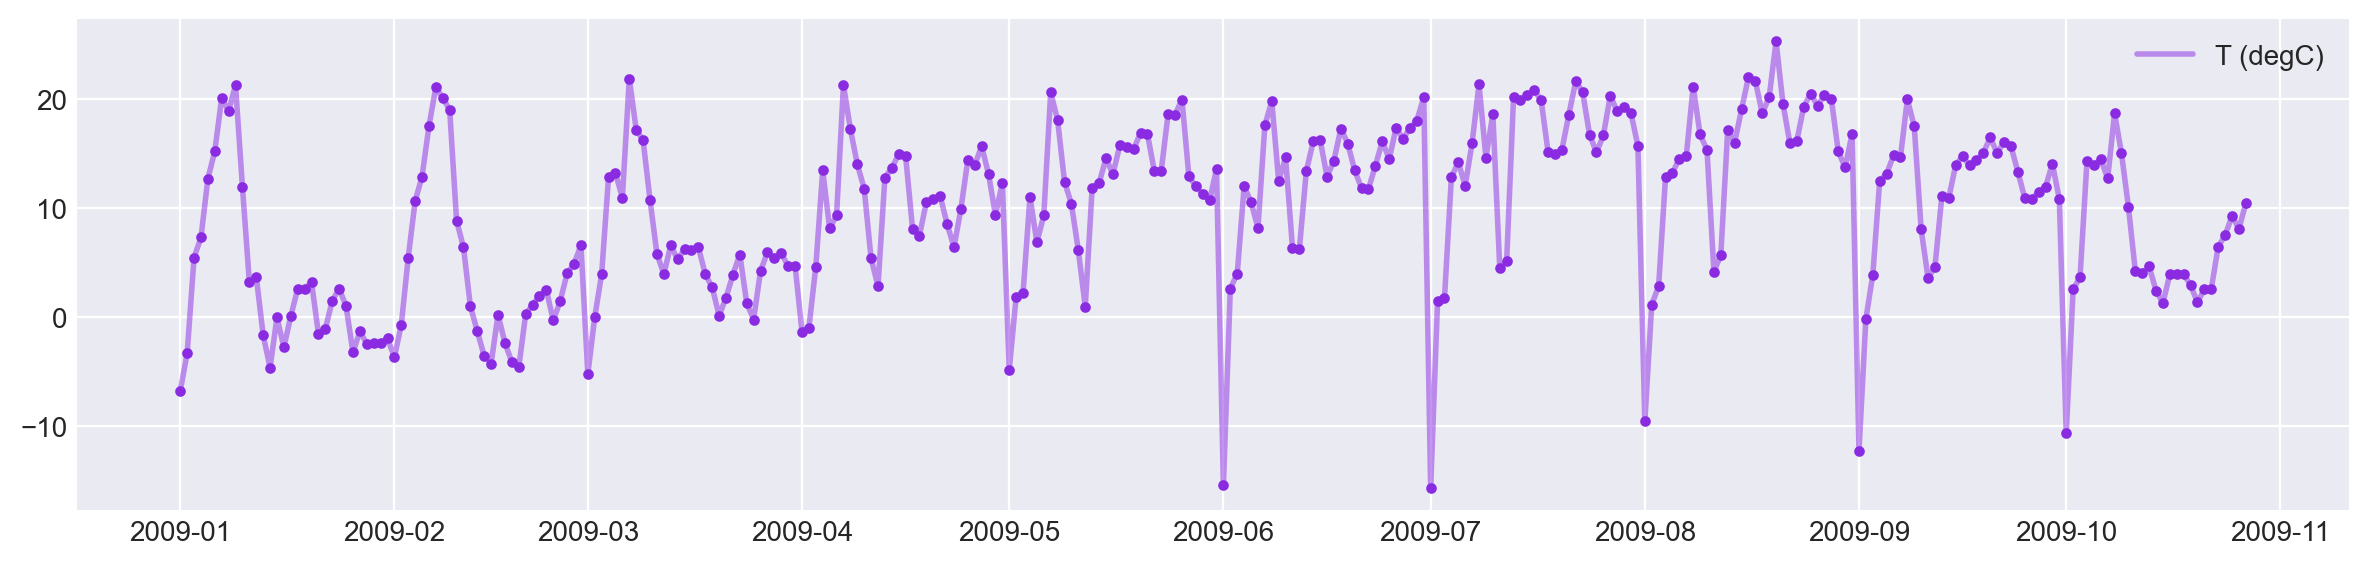

In [6]:
show_dataset(dataframe[:300], columns=["T (degC)"])

In [7]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "T (degC)"
TEST_SIZE = 30

In [8]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (2893, 14)
Test  Size after Test_Train Split: (30, 14) 
train_data shape after Feature Union (2893, 33)
test_data shape after Feature Union (30, 33)
train_data shape after Null Removal (2891, 33)
test_data shape after Null Removal (30, 33)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
Date Time,,,,,,,,,,,,,,,,,,,,,
2016-12-03,1003.414861,1.385139,274.277847,0.160417,91.541667,6.754861,6.185833,0.568472,3.843681,6.164931,...,3.0,48.0,1.0,0.0,0.141120,-0.989992,-0.536573,0.843854,-0.961389,0.275192
2016-12-04,984.365486,9.739444,284.178194,6.018542,79.604097,12.577083,9.431389,3.145139,5.982292,9.582361,...,4.0,48.0,1.0,0.0,-0.756802,-0.653644,-0.536573,0.843854,-0.287874,0.957668
2016-12-05,974.827500,16.687500,291.969583,9.388056,63.751528,19.360347,11.842500,7.517083,7.592431,12.149931,...,5.0,49.0,0.0,1.0,-0.958924,0.283662,-0.536573,0.843854,0.650311,0.759668
2016-12-06,981.777639,16.083958,290.769375,12.605417,80.550208,18.443056,14.654306,3.787986,9.337917,14.928056,...,6.0,49.0,0.0,1.0,-0.279415,0.960170,-0.536573,0.843854,0.990603,-0.136767
2016-12-07,985.962708,20.098125,294.446528,11.862708,59.502847,23.658333,13.921528,9.736667,8.829583,14.119653,...,7.0,49.0,0.0,1.0,0.656987,0.753902,-0.536573,0.843854,0.420140,-0.907459


In [9]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.880 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.911 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.911 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.895 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.929 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.924 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.917 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.941 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.936 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.924 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.946 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

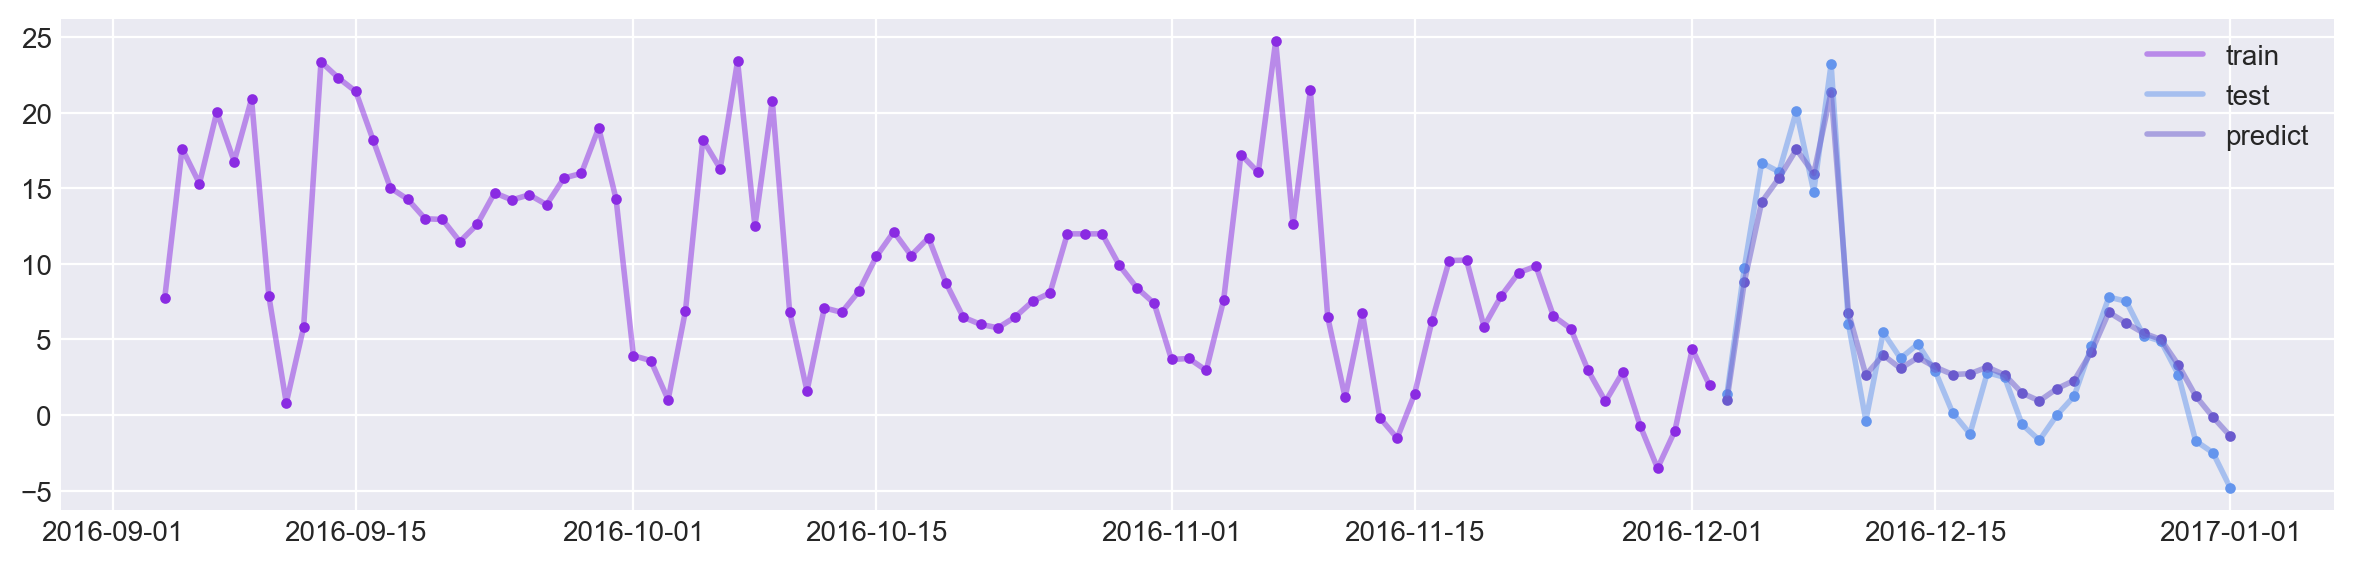

In [11]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [12]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  5  iterations


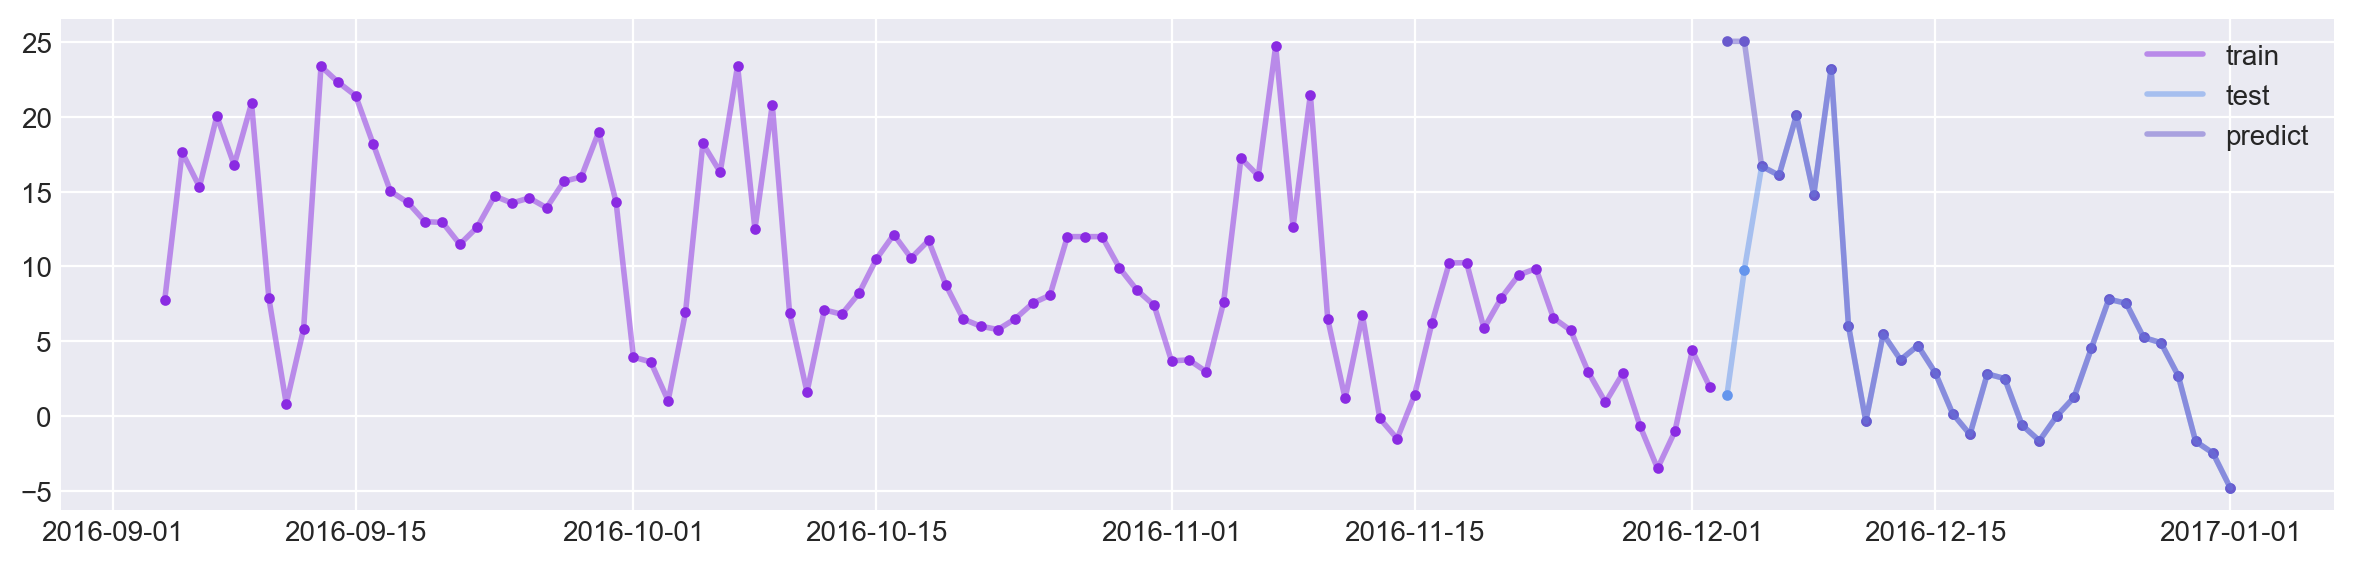

In [13]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [14]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

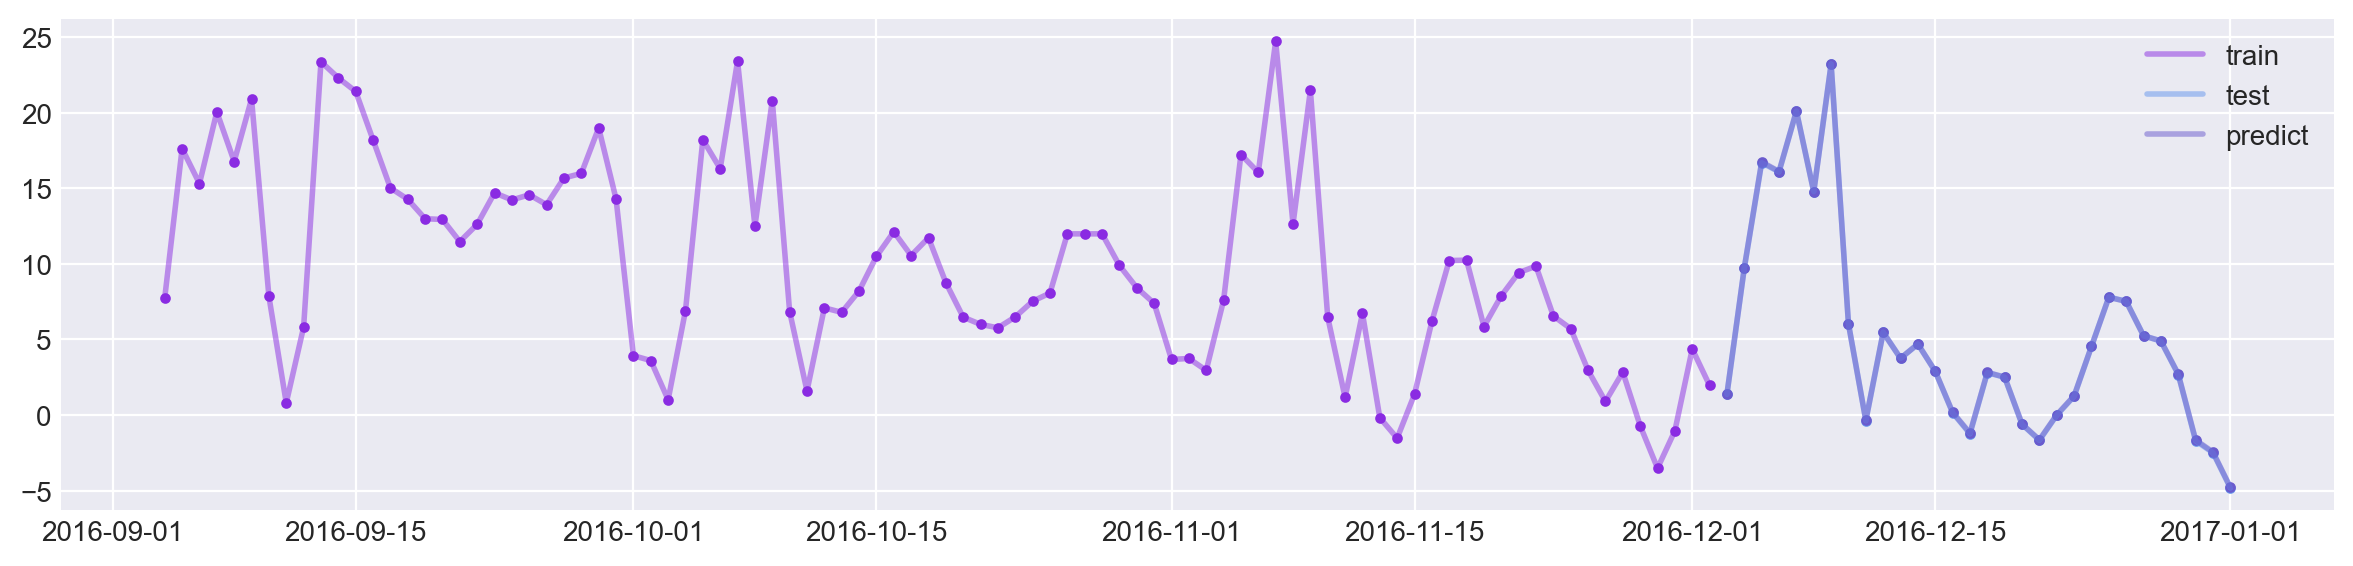

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

param_grid = {
    #'bootstrap': [True,False],
    "max_depth": [7, 8, 9],
    "min_samples_leaf": [2, 3],
    "min_samples_split": [7, 8],
    "n_estimators": [300, 500, 600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.998 total time=   3.5s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.999 total time=   7.2s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.999 total time=  11.0s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.999 total time=   4.7s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.999 total time=   9.3s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.999 total time=  14.9s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.999 total time=   5.8s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.999 total time=  12.0s
[C

[CV 2/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.999 total time=  11.3s
[CV 3/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.999 total time=  18.4s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.999 total time=   2.8s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.999 total time=   6.1s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.999 total time=   9.6s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.999 total time=   5.2s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.999 total time=  11.1s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.999 total time=  18.4s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=

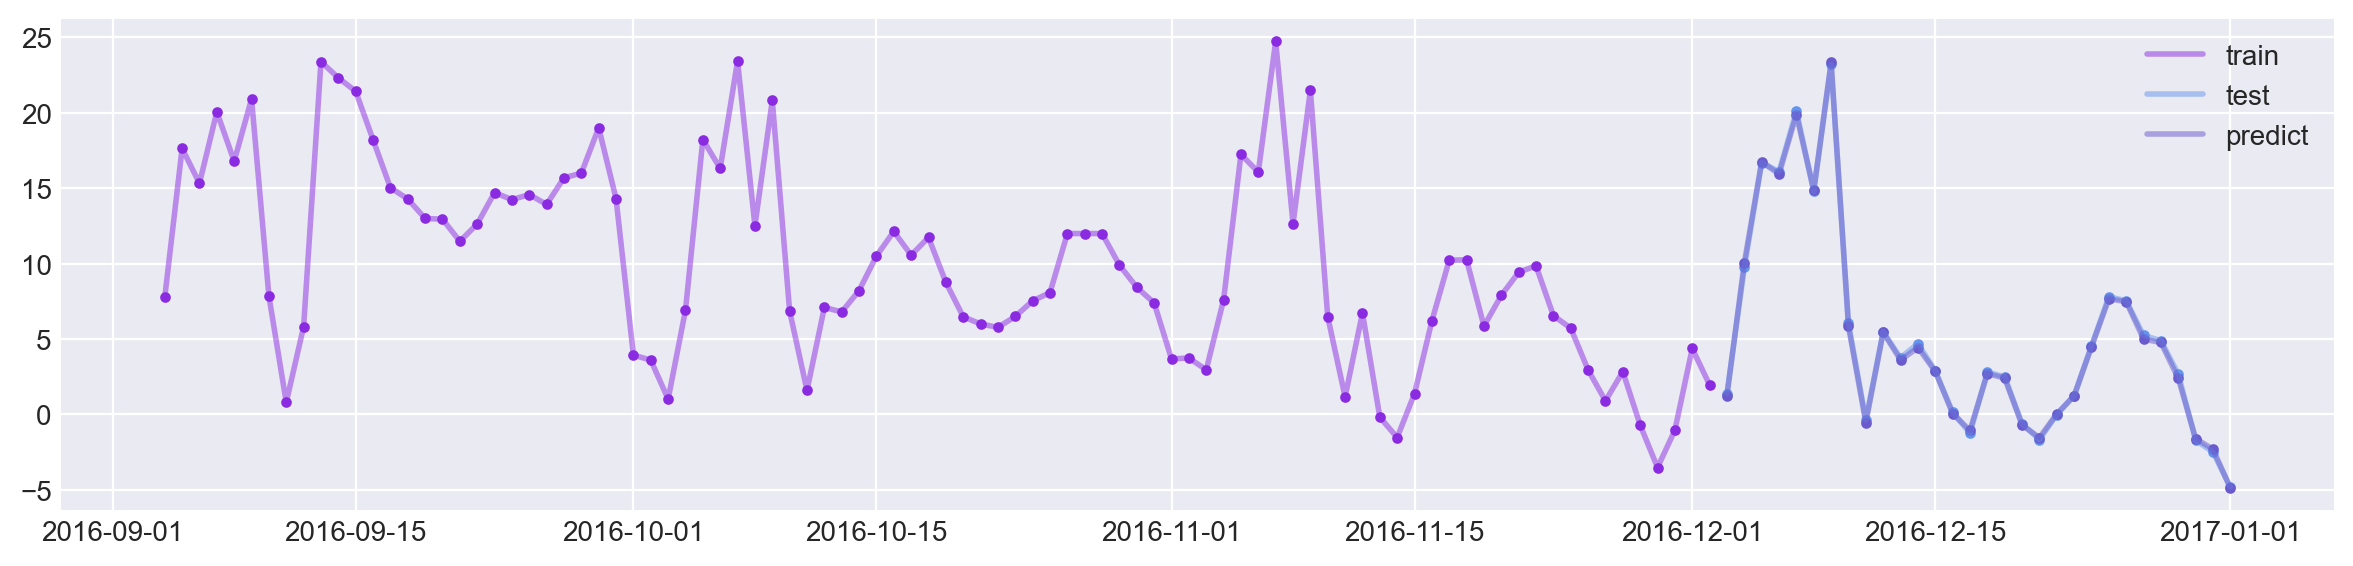

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:9.93554	validation_1-mae:5.63668
[1]	validation_0-mae:9.83687	validation_1-mae:5.58045
[2]	validation_0-mae:9.73923	validation_1-mae:5.52472
[3]	validation_0-mae:9.64251	validation_1-mae:5.47131
[4]	validation_0-mae:9.54675	validation_1-mae:5.41706
[5]	validation_0-mae:9.45199	validation_1-mae:5.36382
[6]	validation_0-mae:9.35816	validation_1-mae:5.31126
[7]	validation_0-mae:9.26527	validation_1-mae:5.25991
[8]	validation_0-mae:9.17331	validation_1-mae:5.20737
[9]	validation_0-mae:9.08224	validation_1-mae:5.15645
[10]	validation_0-mae:8.99212	validation_1-mae:5.10589
[11]	validation_0-mae:8.90290	validation_1-mae:5.05512
[12]	validation_0-mae:8.81452	validation_1-mae:5.00620
[13]	validation_0-mae:8.72704	validation_1-mae:4.95707
[14]	validation_0-mae:8.64046	validation_1-mae:4.90864
[15]	validation_0-mae:8.55468	validation_1-mae:4.86161
[16]	validation_0-mae:8.46980	validation_1-mae:4.81415
[17]	validation_0-mae:8.38571	validation_1-mae:4.76797
[18]	validation_0-ma

[149]	validation_0-mae:2.25043	validation_1-mae:1.32815
[150]	validation_0-mae:2.22817	validation_1-mae:1.31569
[151]	validation_0-mae:2.20614	validation_1-mae:1.30312
[152]	validation_0-mae:2.18432	validation_1-mae:1.29109
[153]	validation_0-mae:2.16273	validation_1-mae:1.27883
[154]	validation_0-mae:2.14135	validation_1-mae:1.26693
[155]	validation_0-mae:2.12020	validation_1-mae:1.25513
[156]	validation_0-mae:2.09923	validation_1-mae:1.24355
[157]	validation_0-mae:2.07849	validation_1-mae:1.23173
[158]	validation_0-mae:2.05794	validation_1-mae:1.22000
[159]	validation_0-mae:2.03760	validation_1-mae:1.20818
[160]	validation_0-mae:2.01746	validation_1-mae:1.19689
[161]	validation_0-mae:1.99753	validation_1-mae:1.18574
[162]	validation_0-mae:1.97778	validation_1-mae:1.17457
[163]	validation_0-mae:1.95824	validation_1-mae:1.16324
[164]	validation_0-mae:1.93888	validation_1-mae:1.15209
[165]	validation_0-mae:1.91971	validation_1-mae:1.14118
[166]	validation_0-mae:1.90073	validation_1-mae:

[296]	validation_0-mae:0.53009	validation_1-mae:0.34620
[297]	validation_0-mae:0.52502	validation_1-mae:0.34357
[298]	validation_0-mae:0.52000	validation_1-mae:0.34091
[299]	validation_0-mae:0.51506	validation_1-mae:0.33842
[300]	validation_0-mae:0.51014	validation_1-mae:0.33588
[301]	validation_0-mae:0.50529	validation_1-mae:0.33302
[302]	validation_0-mae:0.50047	validation_1-mae:0.33049
[303]	validation_0-mae:0.49572	validation_1-mae:0.32809
[304]	validation_0-mae:0.49102	validation_1-mae:0.32568
[305]	validation_0-mae:0.48635	validation_1-mae:0.32322
[306]	validation_0-mae:0.48175	validation_1-mae:0.32044
[307]	validation_0-mae:0.47718	validation_1-mae:0.31805
[308]	validation_0-mae:0.47267	validation_1-mae:0.31559
[309]	validation_0-mae:0.46819	validation_1-mae:0.31339
[310]	validation_0-mae:0.46376	validation_1-mae:0.31102
[311]	validation_0-mae:0.45936	validation_1-mae:0.30901
[312]	validation_0-mae:0.45500	validation_1-mae:0.30674
[313]	validation_0-mae:0.45071	validation_1-mae:

[443]	validation_0-mae:0.14824	validation_1-mae:0.14733
[444]	validation_0-mae:0.14722	validation_1-mae:0.14676
[445]	validation_0-mae:0.14621	validation_1-mae:0.14625
[446]	validation_0-mae:0.14518	validation_1-mae:0.14585
[447]	validation_0-mae:0.14419	validation_1-mae:0.14534
[448]	validation_0-mae:0.14320	validation_1-mae:0.14475
[449]	validation_0-mae:0.14222	validation_1-mae:0.14421
[450]	validation_0-mae:0.14125	validation_1-mae:0.14369
[451]	validation_0-mae:0.14032	validation_1-mae:0.14319
[452]	validation_0-mae:0.13939	validation_1-mae:0.14269
[453]	validation_0-mae:0.13846	validation_1-mae:0.14202
[454]	validation_0-mae:0.13752	validation_1-mae:0.14155
[455]	validation_0-mae:0.13662	validation_1-mae:0.14110
[456]	validation_0-mae:0.13573	validation_1-mae:0.14063
[457]	validation_0-mae:0.13485	validation_1-mae:0.14009
[458]	validation_0-mae:0.13395	validation_1-mae:0.13950
[459]	validation_0-mae:0.13309	validation_1-mae:0.13912
[460]	validation_0-mae:0.13224	validation_1-mae:

[590]	validation_0-mae:0.07605	validation_1-mae:0.11141
[591]	validation_0-mae:0.07586	validation_1-mae:0.11141
[592]	validation_0-mae:0.07568	validation_1-mae:0.11129
[593]	validation_0-mae:0.07551	validation_1-mae:0.11127
[594]	validation_0-mae:0.07535	validation_1-mae:0.11122
[595]	validation_0-mae:0.07518	validation_1-mae:0.11122
[596]	validation_0-mae:0.07500	validation_1-mae:0.11119
[597]	validation_0-mae:0.07483	validation_1-mae:0.11118
[598]	validation_0-mae:0.07467	validation_1-mae:0.11107
[599]	validation_0-mae:0.07451	validation_1-mae:0.11107
[600]	validation_0-mae:0.07434	validation_1-mae:0.11108
[601]	validation_0-mae:0.07417	validation_1-mae:0.11090
[602]	validation_0-mae:0.07402	validation_1-mae:0.11082
[603]	validation_0-mae:0.07387	validation_1-mae:0.11078
[604]	validation_0-mae:0.07372	validation_1-mae:0.11076
[605]	validation_0-mae:0.07357	validation_1-mae:0.11072
[606]	validation_0-mae:0.07342	validation_1-mae:0.11073
[607]	validation_0-mae:0.07327	validation_1-mae:

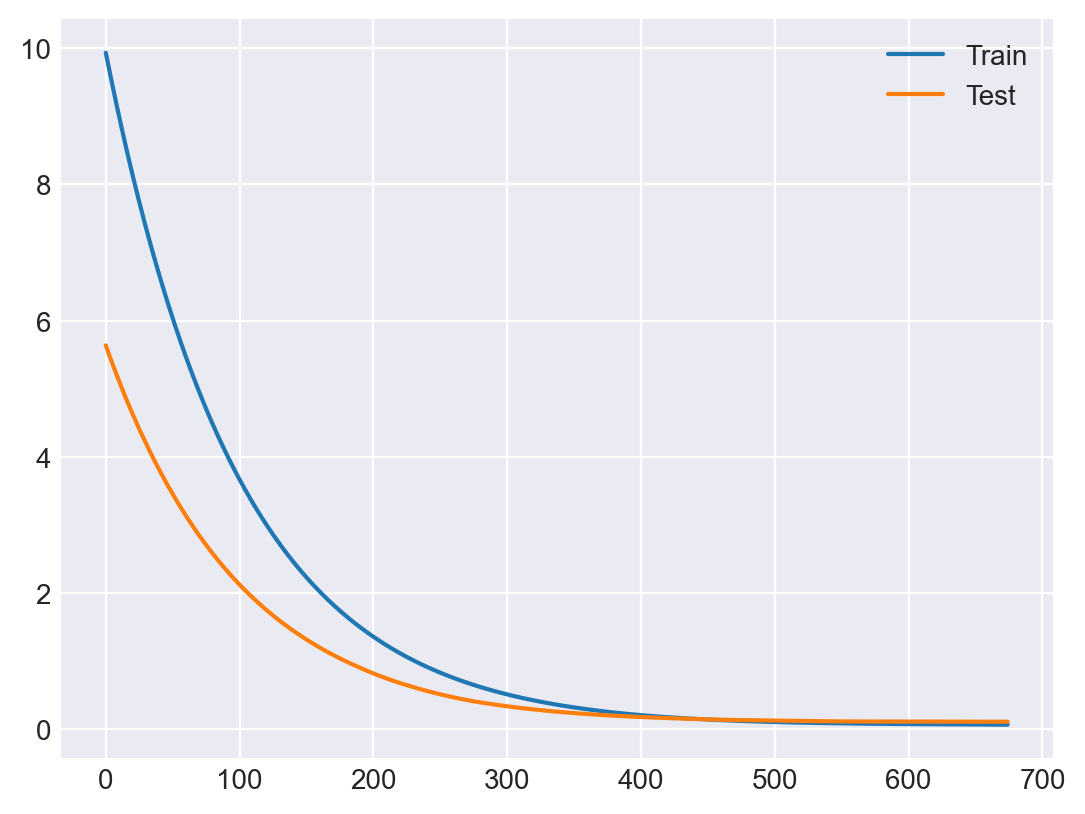

In [18]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

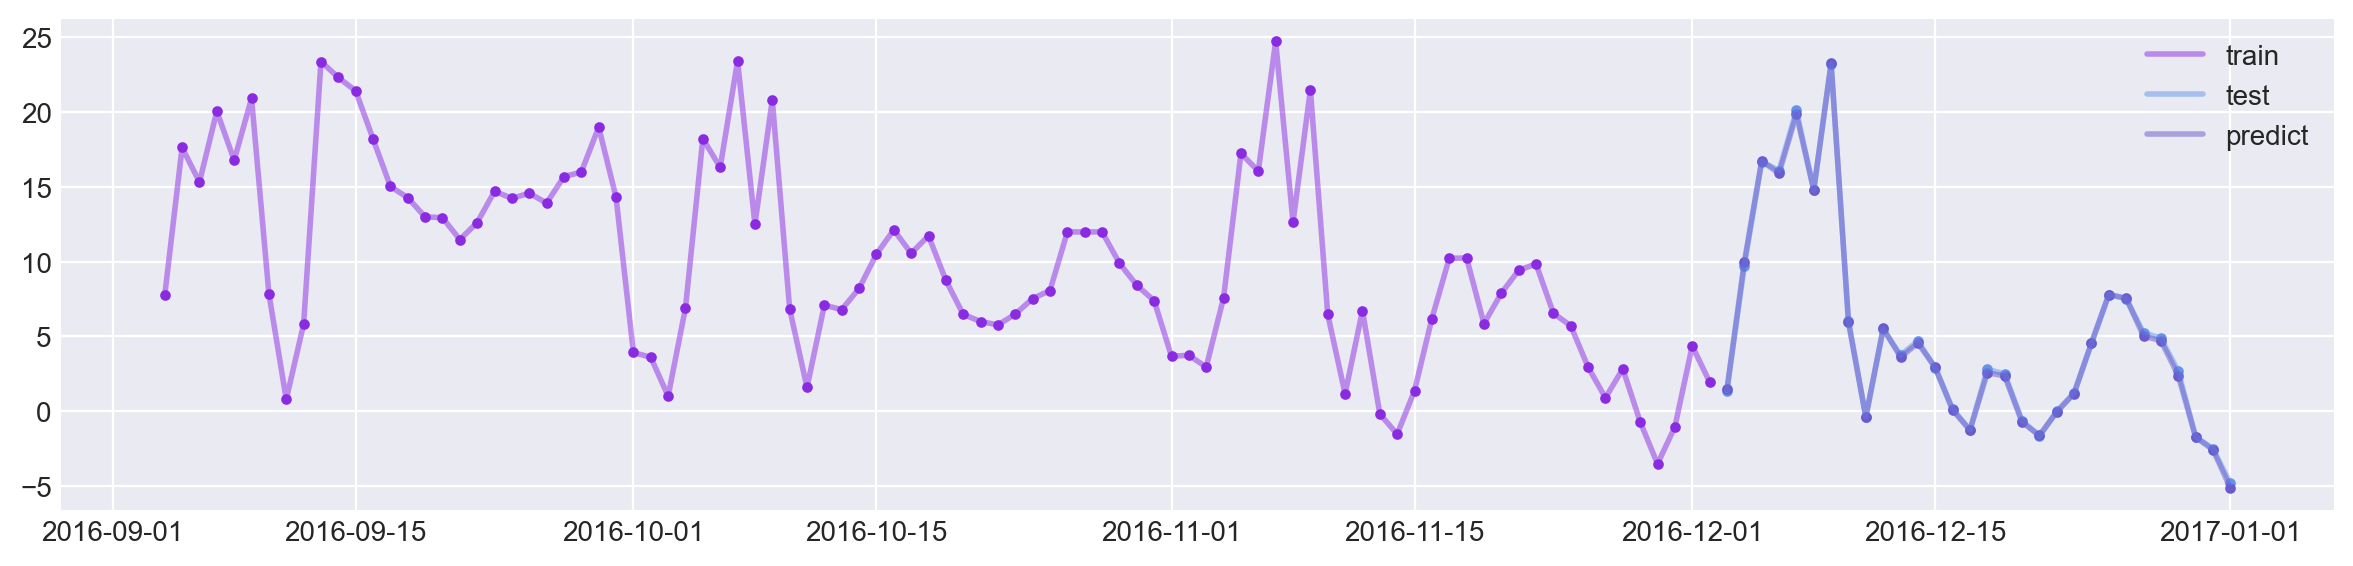

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [20]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    early_stopping_rounds=100,
    verbose=True,
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's l1: 5.8433	training's l2: 49.6572	valid_1's l1: 6.62517	valid_1's l2: 53.6736
[2]	training's l1: 5.25991	training's l2: 40.2604	valid_1's l1: 5.95758	valid_1's l2: 43.4417
[3]	training's l1: 4.73522	training's l2: 32.6395	valid_1's l1: 5.35823	valid_1's l2: 35.2238
[4]	training's l1: 4.26304	training's l2: 26.4654	valid_1's l1: 4.82319	valid_1's l2: 28.6227
[5]	training's l1: 3.83789	training's l2: 21.4642	valid_1's l1: 4.33877	valid_1's l2: 23.2029
[6]	training's l1: 3.45555	training's l2: 17.409	valid_1's l1: 3.89986	valid_1's l2: 18.7907
[7]	training's l1: 3.1113	training's l2: 14.123	valid_1's l1: 3.50637	valid_1's l2: 15.2043
[8]	training's l1: 2.80145	training's l2: 11.4599	valid_1's l1: 3.15247	valid_1's l2: 12.2918
[9]	training's l1: 2.52287	training's l2: 9.30145	valid_1's l1: 2.83676	valid_1's l2: 9.97745
[10]	training's l1: 2.27204	training's l2: 7.55226	valid_1's l1: 2.54954	valid_1's l2: 8.07775
[11]	training's l1: 2.04657	training's l2: 6.13428	valid_1's l1

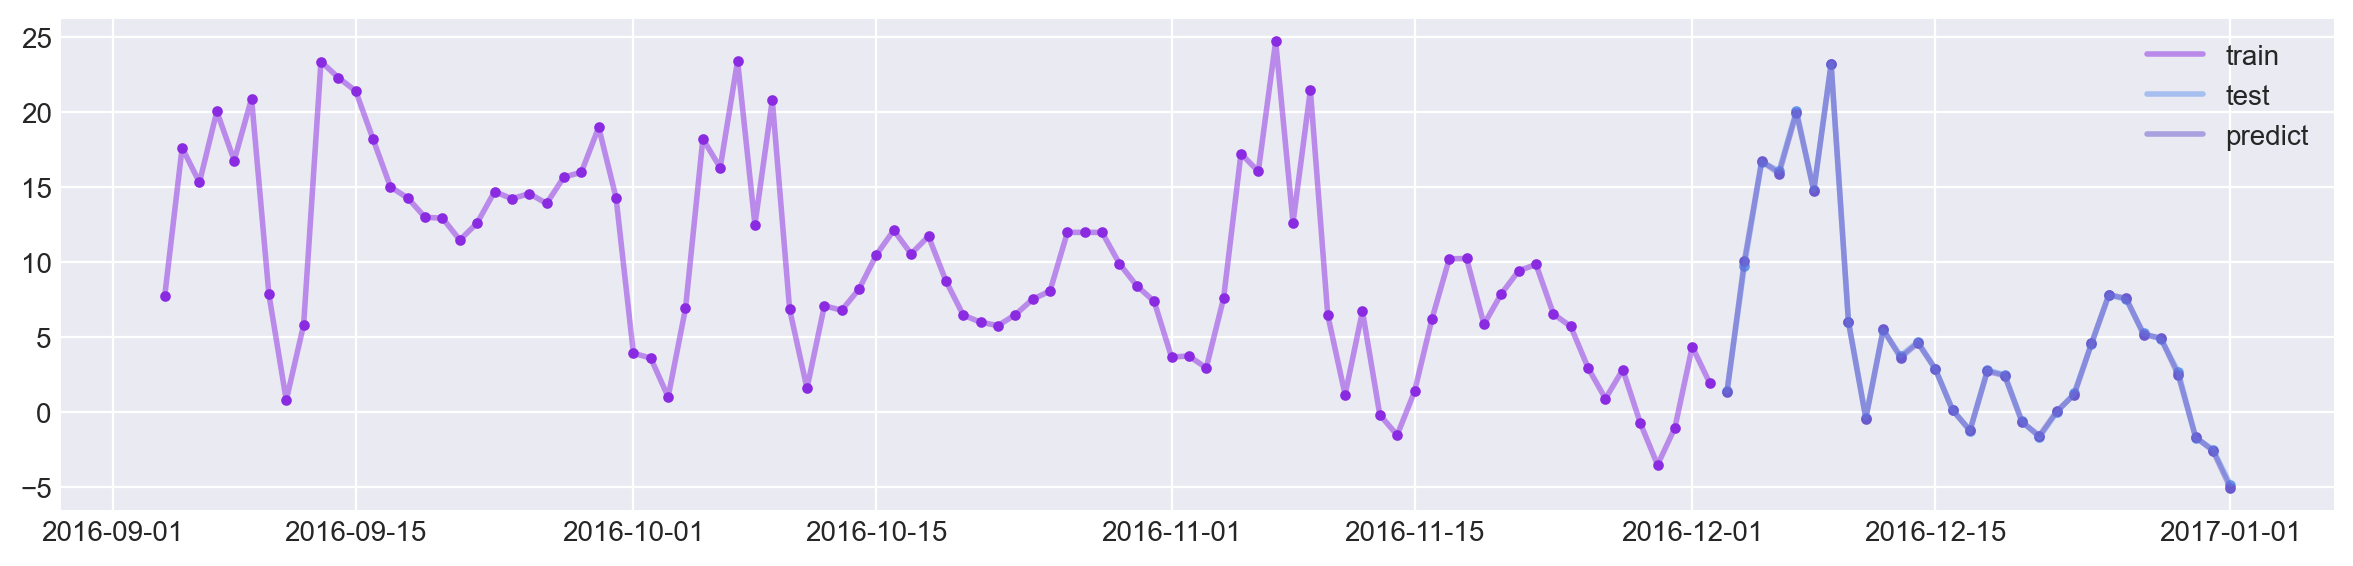

In [21]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [22]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=True
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 10.9296087	test: 12.1356013	best: 12.1356013 (0)	total: 154ms	remaining: 2m 33s
1:	learn: 9.9212928	test: 11.0589444	best: 11.0589444 (1)	total: 158ms	remaining: 1m 19s
2:	learn: 9.0057975	test: 10.0475576	best: 10.0475576 (2)	total: 163ms	remaining: 54.1s
3:	learn: 8.1766972	test: 9.1153752	best: 9.1153752 (3)	total: 167ms	remaining: 41.6s
4:	learn: 7.4324616	test: 8.2840763	best: 8.2840763 (4)	total: 171ms	remaining: 34.1s
5:	learn: 6.7628841	test: 7.5542336	best: 7.5542336 (5)	total: 253ms	remaining: 42s
6:	learn: 6.1695219	test: 6.8810538	best: 6.8810538 (6)	total: 277ms	remaining: 39.3s
7:	learn: 5.6265094	test: 6.2996425	best: 6.2996425 (7)	total: 291ms	remaining: 36s
8:	learn: 5.1506597	test: 5.7623387	best: 5.7623387 (8)	total: 303ms	remaining: 33.4s
9:	learn: 4.7089423	test: 5.2771349	best: 5.2771349 (9)	total: 319ms	remaining: 31.5s
10:	learn: 4.3120583	test: 4.8429602	best: 4.8429602 (10)	total: 332ms	remaining: 29.9s
11:	learn: 3.9338623	test: 4.4317509	best: 4.43

94:	learn: 0.3722029	test: 0.3789071	best: 0.3789071 (94)	total: 1.95s	remaining: 18.6s
95:	learn: 0.3711767	test: 0.3783208	best: 0.3783208 (95)	total: 1.97s	remaining: 18.5s
96:	learn: 0.3690924	test: 0.3761630	best: 0.3761630 (96)	total: 1.98s	remaining: 18.4s
97:	learn: 0.3681798	test: 0.3752813	best: 0.3752813 (97)	total: 1.99s	remaining: 18.3s
98:	learn: 0.3669562	test: 0.3745981	best: 0.3745981 (98)	total: 1.99s	remaining: 18.2s
99:	learn: 0.3661795	test: 0.3739404	best: 0.3739404 (99)	total: 2s	remaining: 18s
100:	learn: 0.3643210	test: 0.3734030	best: 0.3734030 (100)	total: 2.01s	remaining: 17.9s
101:	learn: 0.3623524	test: 0.3720886	best: 0.3720886 (101)	total: 2.01s	remaining: 17.7s
102:	learn: 0.3613541	test: 0.3717302	best: 0.3717302 (102)	total: 2.02s	remaining: 17.6s
103:	learn: 0.3588829	test: 0.3695647	best: 0.3695647 (103)	total: 2.02s	remaining: 17.4s
104:	learn: 0.3572735	test: 0.3685047	best: 0.3685047 (104)	total: 2.03s	remaining: 17.3s
105:	learn: 0.3562879	test:

189:	learn: 0.2736442	test: 0.3220781	best: 0.3220781 (189)	total: 3.73s	remaining: 15.9s
190:	learn: 0.2723914	test: 0.3206731	best: 0.3206731 (190)	total: 3.76s	remaining: 15.9s
191:	learn: 0.2718340	test: 0.3207244	best: 0.3206731 (190)	total: 3.79s	remaining: 15.9s
192:	learn: 0.2714787	test: 0.3207752	best: 0.3206731 (190)	total: 3.81s	remaining: 15.9s
193:	learn: 0.2704332	test: 0.3198736	best: 0.3198736 (193)	total: 3.81s	remaining: 15.9s
194:	learn: 0.2698463	test: 0.3197740	best: 0.3197740 (194)	total: 3.82s	remaining: 15.8s
195:	learn: 0.2694202	test: 0.3198970	best: 0.3197740 (194)	total: 3.83s	remaining: 15.7s
196:	learn: 0.2688416	test: 0.3196616	best: 0.3196616 (196)	total: 3.84s	remaining: 15.7s
197:	learn: 0.2682889	test: 0.3196080	best: 0.3196080 (197)	total: 3.85s	remaining: 15.6s
198:	learn: 0.2679177	test: 0.3195740	best: 0.3195740 (198)	total: 3.86s	remaining: 15.5s
199:	learn: 0.2668806	test: 0.3190196	best: 0.3190196 (199)	total: 3.87s	remaining: 15.5s
200:	learn

293:	learn: 0.2188911	test: 0.2893490	best: 0.2893490 (293)	total: 5.24s	remaining: 12.6s
294:	learn: 0.2183660	test: 0.2890629	best: 0.2890629 (294)	total: 5.26s	remaining: 12.6s
295:	learn: 0.2180778	test: 0.2890376	best: 0.2890376 (295)	total: 5.29s	remaining: 12.6s
296:	learn: 0.2177467	test: 0.2886212	best: 0.2886212 (296)	total: 5.31s	remaining: 12.6s
297:	learn: 0.2171438	test: 0.2880657	best: 0.2880657 (297)	total: 5.33s	remaining: 12.6s
298:	learn: 0.2169092	test: 0.2879050	best: 0.2879050 (298)	total: 5.36s	remaining: 12.6s
299:	learn: 0.2165601	test: 0.2878477	best: 0.2878477 (299)	total: 5.37s	remaining: 12.5s
300:	learn: 0.2161370	test: 0.2875482	best: 0.2875482 (300)	total: 5.38s	remaining: 12.5s
301:	learn: 0.2150250	test: 0.2865719	best: 0.2865719 (301)	total: 5.41s	remaining: 12.5s
302:	learn: 0.2145222	test: 0.2861989	best: 0.2861989 (302)	total: 5.43s	remaining: 12.5s
303:	learn: 0.2142693	test: 0.2861046	best: 0.2861046 (303)	total: 5.46s	remaining: 12.5s
304:	learn

385:	learn: 0.1870681	test: 0.2674576	best: 0.2674576 (385)	total: 6.81s	remaining: 10.8s
386:	learn: 0.1867865	test: 0.2673661	best: 0.2673661 (386)	total: 6.84s	remaining: 10.8s
387:	learn: 0.1866352	test: 0.2673668	best: 0.2673661 (386)	total: 6.86s	remaining: 10.8s
388:	learn: 0.1860905	test: 0.2667425	best: 0.2667425 (388)	total: 6.88s	remaining: 10.8s
389:	learn: 0.1857982	test: 0.2664815	best: 0.2664815 (389)	total: 6.91s	remaining: 10.8s
390:	learn: 0.1855907	test: 0.2665101	best: 0.2664815 (389)	total: 6.93s	remaining: 10.8s
391:	learn: 0.1851780	test: 0.2662341	best: 0.2662341 (391)	total: 6.96s	remaining: 10.8s
392:	learn: 0.1848560	test: 0.2658226	best: 0.2658226 (392)	total: 6.98s	remaining: 10.8s
393:	learn: 0.1845621	test: 0.2656777	best: 0.2656777 (393)	total: 7s	remaining: 10.8s
394:	learn: 0.1842588	test: 0.2658682	best: 0.2656777 (393)	total: 7.03s	remaining: 10.8s
395:	learn: 0.1839675	test: 0.2656878	best: 0.2656777 (393)	total: 7.05s	remaining: 10.7s
396:	learn: 0

487:	learn: 0.1610442	test: 0.2514421	best: 0.2514421 (487)	total: 8.29s	remaining: 8.7s
488:	learn: 0.1607974	test: 0.2512749	best: 0.2512749 (488)	total: 8.3s	remaining: 8.67s
489:	learn: 0.1606764	test: 0.2512787	best: 0.2512749 (488)	total: 8.3s	remaining: 8.64s
490:	learn: 0.1604671	test: 0.2511367	best: 0.2511367 (490)	total: 8.31s	remaining: 8.62s
491:	learn: 0.1602915	test: 0.2510801	best: 0.2510801 (491)	total: 8.33s	remaining: 8.6s
492:	learn: 0.1600920	test: 0.2510502	best: 0.2510502 (492)	total: 8.34s	remaining: 8.58s
493:	learn: 0.1598025	test: 0.2508277	best: 0.2508277 (493)	total: 8.35s	remaining: 8.55s
494:	learn: 0.1596682	test: 0.2508045	best: 0.2508045 (494)	total: 8.36s	remaining: 8.53s
495:	learn: 0.1594893	test: 0.2508209	best: 0.2508045 (494)	total: 8.38s	remaining: 8.51s
496:	learn: 0.1592465	test: 0.2506572	best: 0.2506572 (496)	total: 8.39s	remaining: 8.49s
497:	learn: 0.1590962	test: 0.2506495	best: 0.2506495 (497)	total: 8.4s	remaining: 8.47s
498:	learn: 0.1

598:	learn: 0.1409562	test: 0.2424225	best: 0.2424225 (598)	total: 9.85s	remaining: 6.59s
599:	learn: 0.1407907	test: 0.2423196	best: 0.2423196 (599)	total: 9.87s	remaining: 6.58s
600:	learn: 0.1406811	test: 0.2422922	best: 0.2422922 (600)	total: 9.89s	remaining: 6.56s
601:	learn: 0.1404848	test: 0.2420708	best: 0.2420708 (601)	total: 9.9s	remaining: 6.55s
602:	learn: 0.1404002	test: 0.2420905	best: 0.2420708 (601)	total: 9.91s	remaining: 6.53s
603:	learn: 0.1402284	test: 0.2420198	best: 0.2420198 (603)	total: 9.93s	remaining: 6.51s
604:	learn: 0.1401282	test: 0.2419061	best: 0.2419061 (604)	total: 9.95s	remaining: 6.5s
605:	learn: 0.1400157	test: 0.2419314	best: 0.2419061 (604)	total: 9.97s	remaining: 6.48s
606:	learn: 0.1399138	test: 0.2418680	best: 0.2418680 (606)	total: 9.98s	remaining: 6.46s
607:	learn: 0.1397491	test: 0.2419032	best: 0.2418680 (606)	total: 9.99s	remaining: 6.44s
608:	learn: 0.1396207	test: 0.2417619	best: 0.2417619 (608)	total: 10s	remaining: 6.42s
609:	learn: 0.

717:	learn: 0.1234734	test: 0.2327495	best: 0.2326435 (714)	total: 10.7s	remaining: 4.2s
718:	learn: 0.1233326	test: 0.2326630	best: 0.2326435 (714)	total: 10.7s	remaining: 4.18s
719:	learn: 0.1231651	test: 0.2325937	best: 0.2325937 (719)	total: 10.7s	remaining: 4.16s
720:	learn: 0.1230515	test: 0.2326471	best: 0.2325937 (719)	total: 10.7s	remaining: 4.14s
721:	learn: 0.1228982	test: 0.2325651	best: 0.2325651 (721)	total: 10.7s	remaining: 4.12s
722:	learn: 0.1227937	test: 0.2325291	best: 0.2325291 (722)	total: 10.7s	remaining: 4.1s
723:	learn: 0.1227044	test: 0.2324850	best: 0.2324850 (723)	total: 10.7s	remaining: 4.08s
724:	learn: 0.1225561	test: 0.2324346	best: 0.2324346 (724)	total: 10.7s	remaining: 4.06s
725:	learn: 0.1224822	test: 0.2323905	best: 0.2323905 (725)	total: 10.7s	remaining: 4.04s
726:	learn: 0.1222790	test: 0.2323449	best: 0.2323449 (726)	total: 10.7s	remaining: 4.02s
727:	learn: 0.1221738	test: 0.2323482	best: 0.2323449 (726)	total: 10.7s	remaining: 4s
728:	learn: 0.1

829:	learn: 0.1096550	test: 0.2263771	best: 0.2263771 (829)	total: 11.3s	remaining: 2.32s
830:	learn: 0.1095844	test: 0.2263550	best: 0.2263550 (830)	total: 11.3s	remaining: 2.3s
831:	learn: 0.1094711	test: 0.2263077	best: 0.2263077 (831)	total: 11.3s	remaining: 2.29s
832:	learn: 0.1093983	test: 0.2262908	best: 0.2262908 (832)	total: 11.3s	remaining: 2.27s
833:	learn: 0.1092367	test: 0.2262238	best: 0.2262238 (833)	total: 11.3s	remaining: 2.25s
834:	learn: 0.1091168	test: 0.2261799	best: 0.2261799 (834)	total: 11.3s	remaining: 2.24s
835:	learn: 0.1090558	test: 0.2261353	best: 0.2261353 (835)	total: 11.3s	remaining: 2.22s
836:	learn: 0.1090023	test: 0.2261211	best: 0.2261211 (836)	total: 11.3s	remaining: 2.21s
837:	learn: 0.1089018	test: 0.2261302	best: 0.2261211 (836)	total: 11.3s	remaining: 2.19s
838:	learn: 0.1088252	test: 0.2261225	best: 0.2261211 (836)	total: 11.3s	remaining: 2.17s
839:	learn: 0.1087257	test: 0.2261019	best: 0.2261019 (839)	total: 11.3s	remaining: 2.16s
840:	learn:

921:	learn: 0.1007621	test: 0.2237795	best: 0.2237795 (921)	total: 12.2s	remaining: 1.03s
922:	learn: 0.1006632	test: 0.2239177	best: 0.2237795 (921)	total: 12.2s	remaining: 1.02s
923:	learn: 0.1005844	test: 0.2239164	best: 0.2237795 (921)	total: 12.2s	remaining: 1s
924:	learn: 0.1005237	test: 0.2238983	best: 0.2237795 (921)	total: 12.2s	remaining: 993ms
925:	learn: 0.1004605	test: 0.2238552	best: 0.2237795 (921)	total: 12.3s	remaining: 980ms
926:	learn: 0.1003793	test: 0.2238277	best: 0.2237795 (921)	total: 12.3s	remaining: 966ms
927:	learn: 0.1003321	test: 0.2237648	best: 0.2237648 (927)	total: 12.3s	remaining: 953ms
928:	learn: 0.1001959	test: 0.2236378	best: 0.2236378 (928)	total: 12.3s	remaining: 941ms
929:	learn: 0.1000992	test: 0.2236232	best: 0.2236232 (929)	total: 12.3s	remaining: 928ms
930:	learn: 0.1000367	test: 0.2236520	best: 0.2236232 (929)	total: 12.4s	remaining: 916ms
931:	learn: 0.0999537	test: 0.2235338	best: 0.2235338 (931)	total: 12.4s	remaining: 903ms
932:	learn: 0

21:	learn: 1.7775419	test: 1.9526587	best: 1.9526587 (21)	total: 307ms	remaining: 13.6s
22:	learn: 1.6602973	test: 1.8115751	best: 1.8115751 (22)	total: 328ms	remaining: 14s
23:	learn: 1.5459544	test: 1.6844454	best: 1.6844454 (23)	total: 351ms	remaining: 14.3s
24:	learn: 1.4421874	test: 1.5648398	best: 1.5648398 (24)	total: 364ms	remaining: 14.2s
25:	learn: 1.3573685	test: 1.4639152	best: 1.4639152 (25)	total: 376ms	remaining: 14.1s
26:	learn: 1.2669743	test: 1.3588844	best: 1.3588844 (26)	total: 400ms	remaining: 14.4s
27:	learn: 1.1921447	test: 1.2670442	best: 1.2670442 (27)	total: 422ms	remaining: 14.7s
28:	learn: 1.1271967	test: 1.1951586	best: 1.1951586 (28)	total: 444ms	remaining: 14.9s
29:	learn: 1.0653832	test: 1.1179557	best: 1.1179557 (29)	total: 467ms	remaining: 15.1s
30:	learn: 1.0113489	test: 1.0508212	best: 1.0508212 (30)	total: 483ms	remaining: 15.1s
31:	learn: 0.9617239	test: 0.9834412	best: 0.9834412 (31)	total: 496ms	remaining: 15s
32:	learn: 0.9138663	test: 0.9266309

118:	learn: 0.3445762	test: 0.3572813	best: 0.3572813 (118)	total: 1.92s	remaining: 14.2s
119:	learn: 0.3435721	test: 0.3570736	best: 0.3570736 (119)	total: 1.92s	remaining: 14.1s
120:	learn: 0.3430569	test: 0.3569908	best: 0.3569908 (120)	total: 1.93s	remaining: 14s
121:	learn: 0.3418390	test: 0.3564050	best: 0.3564050 (121)	total: 1.93s	remaining: 13.9s
122:	learn: 0.3409429	test: 0.3561674	best: 0.3561674 (122)	total: 1.94s	remaining: 13.8s
123:	learn: 0.3389782	test: 0.3546697	best: 0.3546697 (123)	total: 1.94s	remaining: 13.7s
124:	learn: 0.3377727	test: 0.3542993	best: 0.3542993 (124)	total: 1.95s	remaining: 13.6s
125:	learn: 0.3363044	test: 0.3535843	best: 0.3535843 (125)	total: 1.95s	remaining: 13.6s
126:	learn: 0.3359559	test: 0.3535154	best: 0.3535154 (126)	total: 1.96s	remaining: 13.5s
127:	learn: 0.3357765	test: 0.3535907	best: 0.3535154 (126)	total: 1.99s	remaining: 13.5s
128:	learn: 0.3351476	test: 0.3536145	best: 0.3535154 (126)	total: 2.01s	remaining: 13.6s
129:	learn: 

211:	learn: 0.2679294	test: 0.3138783	best: 0.3138783 (211)	total: 3.02s	remaining: 11.2s
212:	learn: 0.2671079	test: 0.3129345	best: 0.3129345 (212)	total: 3.05s	remaining: 11.3s
213:	learn: 0.2667453	test: 0.3128046	best: 0.3128046 (213)	total: 3.06s	remaining: 11.2s
214:	learn: 0.2660625	test: 0.3118920	best: 0.3118920 (214)	total: 3.08s	remaining: 11.2s
215:	learn: 0.2656470	test: 0.3116079	best: 0.3116079 (215)	total: 3.09s	remaining: 11.2s
216:	learn: 0.2647462	test: 0.3106948	best: 0.3106948 (216)	total: 3.1s	remaining: 11.2s
217:	learn: 0.2641871	test: 0.3102237	best: 0.3102237 (217)	total: 3.12s	remaining: 11.2s
218:	learn: 0.2639805	test: 0.3101982	best: 0.3101982 (218)	total: 3.15s	remaining: 11.2s
219:	learn: 0.2632129	test: 0.3093163	best: 0.3093163 (219)	total: 3.17s	remaining: 11.2s
220:	learn: 0.2627309	test: 0.3092892	best: 0.3092892 (220)	total: 3.19s	remaining: 11.2s
221:	learn: 0.2616610	test: 0.3081597	best: 0.3081597 (221)	total: 3.2s	remaining: 11.2s
222:	learn: 

313:	learn: 0.2197963	test: 0.2818930	best: 0.2818930 (313)	total: 5.03s	remaining: 11s
314:	learn: 0.2194593	test: 0.2817712	best: 0.2817712 (314)	total: 5.06s	remaining: 11s
315:	learn: 0.2192892	test: 0.2815885	best: 0.2815885 (315)	total: 5.08s	remaining: 11s
316:	learn: 0.2188065	test: 0.2812726	best: 0.2812726 (316)	total: 5.09s	remaining: 11s
317:	learn: 0.2187292	test: 0.2812737	best: 0.2812726 (316)	total: 5.1s	remaining: 10.9s
318:	learn: 0.2182748	test: 0.2812076	best: 0.2812076 (318)	total: 5.13s	remaining: 10.9s
319:	learn: 0.2181800	test: 0.2811873	best: 0.2811873 (319)	total: 5.15s	remaining: 10.9s
320:	learn: 0.2178674	test: 0.2810206	best: 0.2810206 (320)	total: 5.17s	remaining: 10.9s
321:	learn: 0.2175526	test: 0.2807499	best: 0.2807499 (321)	total: 5.19s	remaining: 10.9s
322:	learn: 0.2172677	test: 0.2805216	best: 0.2805216 (322)	total: 5.21s	remaining: 10.9s
323:	learn: 0.2168474	test: 0.2803140	best: 0.2803140 (323)	total: 5.23s	remaining: 10.9s
324:	learn: 0.21658

405:	learn: 0.1916423	test: 0.2652212	best: 0.2651145 (404)	total: 6.81s	remaining: 9.96s
406:	learn: 0.1912110	test: 0.2650235	best: 0.2650235 (406)	total: 6.83s	remaining: 9.95s
407:	learn: 0.1908360	test: 0.2647677	best: 0.2647677 (407)	total: 6.85s	remaining: 9.94s
408:	learn: 0.1904160	test: 0.2644798	best: 0.2644798 (408)	total: 6.88s	remaining: 9.94s
409:	learn: 0.1898796	test: 0.2641788	best: 0.2641788 (409)	total: 6.89s	remaining: 9.92s
410:	learn: 0.1894972	test: 0.2639608	best: 0.2639608 (410)	total: 6.91s	remaining: 9.9s
411:	learn: 0.1894611	test: 0.2639750	best: 0.2639608 (410)	total: 6.94s	remaining: 9.91s
412:	learn: 0.1894125	test: 0.2639964	best: 0.2639608 (410)	total: 6.96s	remaining: 9.9s
413:	learn: 0.1892489	test: 0.2640562	best: 0.2639608 (410)	total: 6.99s	remaining: 9.89s
414:	learn: 0.1890694	test: 0.2638852	best: 0.2638852 (414)	total: 7s	remaining: 9.87s
415:	learn: 0.1890371	test: 0.2639103	best: 0.2638852 (414)	total: 7s	remaining: 9.83s
416:	learn: 0.1887

514:	learn: 0.1654807	test: 0.2511111	best: 0.2507426 (509)	total: 8.1s	remaining: 7.63s
515:	learn: 0.1653643	test: 0.2511325	best: 0.2507426 (509)	total: 8.12s	remaining: 7.62s
516:	learn: 0.1651436	test: 0.2508486	best: 0.2507426 (509)	total: 8.14s	remaining: 7.6s
517:	learn: 0.1649920	test: 0.2507360	best: 0.2507360 (517)	total: 8.15s	remaining: 7.58s
518:	learn: 0.1648501	test: 0.2507703	best: 0.2507360 (517)	total: 8.17s	remaining: 7.57s
519:	learn: 0.1646299	test: 0.2508369	best: 0.2507360 (517)	total: 8.18s	remaining: 7.55s
520:	learn: 0.1645223	test: 0.2508416	best: 0.2507360 (517)	total: 8.2s	remaining: 7.53s
521:	learn: 0.1641330	test: 0.2504786	best: 0.2504786 (521)	total: 8.21s	remaining: 7.51s
522:	learn: 0.1639604	test: 0.2504432	best: 0.2504432 (522)	total: 8.22s	remaining: 7.5s
523:	learn: 0.1639243	test: 0.2504508	best: 0.2504432 (522)	total: 8.25s	remaining: 7.49s
524:	learn: 0.1636504	test: 0.2502938	best: 0.2502938 (524)	total: 8.27s	remaining: 7.48s
525:	learn: 0.

612:	learn: 0.1477836	test: 0.2416513	best: 0.2416031 (610)	total: 9.65s	remaining: 6.09s
613:	learn: 0.1475475	test: 0.2414079	best: 0.2414079 (613)	total: 9.67s	remaining: 6.08s
614:	learn: 0.1474476	test: 0.2411989	best: 0.2411989 (614)	total: 9.69s	remaining: 6.06s
615:	learn: 0.1472648	test: 0.2411645	best: 0.2411645 (615)	total: 9.7s	remaining: 6.04s
616:	learn: 0.1470021	test: 0.2410250	best: 0.2410250 (616)	total: 9.71s	remaining: 6.03s
617:	learn: 0.1469556	test: 0.2410456	best: 0.2410250 (616)	total: 9.73s	remaining: 6.01s
618:	learn: 0.1468250	test: 0.2410239	best: 0.2410239 (618)	total: 9.75s	remaining: 6s
619:	learn: 0.1467387	test: 0.2410305	best: 0.2410239 (618)	total: 9.77s	remaining: 5.99s
620:	learn: 0.1465447	test: 0.2408584	best: 0.2408584 (620)	total: 9.79s	remaining: 5.97s
621:	learn: 0.1464214	test: 0.2408655	best: 0.2408584 (620)	total: 9.8s	remaining: 5.95s
622:	learn: 0.1464060	test: 0.2408519	best: 0.2408519 (622)	total: 9.81s	remaining: 5.94s
623:	learn: 0.1

712:	learn: 0.1326424	test: 0.2336451	best: 0.2336451 (712)	total: 11.4s	remaining: 4.58s
713:	learn: 0.1326002	test: 0.2336678	best: 0.2336451 (712)	total: 11.4s	remaining: 4.56s
714:	learn: 0.1324562	test: 0.2336733	best: 0.2336451 (712)	total: 11.4s	remaining: 4.55s
715:	learn: 0.1323444	test: 0.2336714	best: 0.2336451 (712)	total: 11.4s	remaining: 4.53s
716:	learn: 0.1321648	test: 0.2337027	best: 0.2336451 (712)	total: 11.4s	remaining: 4.51s
717:	learn: 0.1319778	test: 0.2337324	best: 0.2336451 (712)	total: 11.4s	remaining: 4.5s
718:	learn: 0.1317075	test: 0.2333603	best: 0.2333603 (718)	total: 11.5s	remaining: 4.49s
719:	learn: 0.1315230	test: 0.2332495	best: 0.2332495 (719)	total: 11.5s	remaining: 4.47s
720:	learn: 0.1313530	test: 0.2331272	best: 0.2331272 (720)	total: 11.5s	remaining: 4.46s
721:	learn: 0.1312196	test: 0.2329860	best: 0.2329860 (721)	total: 11.5s	remaining: 4.44s
722:	learn: 0.1309787	test: 0.2328162	best: 0.2328162 (722)	total: 11.6s	remaining: 4.43s
723:	learn:

804:	learn: 0.1211261	test: 0.2279785	best: 0.2278835 (800)	total: 13.2s	remaining: 3.19s
805:	learn: 0.1209114	test: 0.2277354	best: 0.2277354 (805)	total: 13.2s	remaining: 3.18s
806:	learn: 0.1207413	test: 0.2277946	best: 0.2277354 (805)	total: 13.3s	remaining: 3.17s
807:	learn: 0.1205953	test: 0.2278200	best: 0.2277354 (805)	total: 13.3s	remaining: 3.15s
808:	learn: 0.1204773	test: 0.2278652	best: 0.2277354 (805)	total: 13.3s	remaining: 3.13s
809:	learn: 0.1203865	test: 0.2278498	best: 0.2277354 (805)	total: 13.3s	remaining: 3.12s
810:	learn: 0.1202672	test: 0.2277721	best: 0.2277354 (805)	total: 13.3s	remaining: 3.1s
811:	learn: 0.1201177	test: 0.2276276	best: 0.2276276 (811)	total: 13.3s	remaining: 3.09s
812:	learn: 0.1200001	test: 0.2275476	best: 0.2275476 (812)	total: 13.4s	remaining: 3.07s
813:	learn: 0.1198958	test: 0.2274434	best: 0.2274434 (813)	total: 13.4s	remaining: 3.06s
814:	learn: 0.1197622	test: 0.2274222	best: 0.2274222 (814)	total: 13.4s	remaining: 3.04s
815:	learn:

899:	learn: 0.1102559	test: 0.2234258	best: 0.2234258 (899)	total: 15.2s	remaining: 1.69s
900:	learn: 0.1101298	test: 0.2233827	best: 0.2233827 (900)	total: 15.2s	remaining: 1.67s
901:	learn: 0.1100540	test: 0.2232633	best: 0.2232633 (901)	total: 15.2s	remaining: 1.65s
902:	learn: 0.1099695	test: 0.2232557	best: 0.2232557 (902)	total: 15.2s	remaining: 1.64s
903:	learn: 0.1099165	test: 0.2232270	best: 0.2232270 (903)	total: 15.2s	remaining: 1.62s
904:	learn: 0.1097715	test: 0.2231977	best: 0.2231977 (904)	total: 15.3s	remaining: 1.6s
905:	learn: 0.1096527	test: 0.2232115	best: 0.2231977 (904)	total: 15.3s	remaining: 1.58s
906:	learn: 0.1096115	test: 0.2232182	best: 0.2231977 (904)	total: 15.3s	remaining: 1.57s
907:	learn: 0.1095338	test: 0.2232099	best: 0.2231977 (904)	total: 15.3s	remaining: 1.55s
908:	learn: 0.1093952	test: 0.2230830	best: 0.2230830 (908)	total: 15.4s	remaining: 1.54s
909:	learn: 0.1093620	test: 0.2231098	best: 0.2230830 (908)	total: 15.4s	remaining: 1.52s
910:	learn:

0:	learn: 11.3244716	test: 10.8678718	best: 10.8678718 (0)	total: 2.24ms	remaining: 2.24s
1:	learn: 10.2902332	test: 9.8695574	best: 9.8695574 (1)	total: 3.9ms	remaining: 1.95s
2:	learn: 9.3375097	test: 8.9615580	best: 8.9615580 (2)	total: 5.41ms	remaining: 1.8s
3:	learn: 8.4952626	test: 8.1877220	best: 8.1877220 (3)	total: 6.93ms	remaining: 1.73s
4:	learn: 7.7175084	test: 7.4702784	best: 7.4702784 (4)	total: 8.45ms	remaining: 1.68s
5:	learn: 7.0441381	test: 6.8471058	best: 6.8471058 (5)	total: 9.96ms	remaining: 1.65s
6:	learn: 6.4068604	test: 6.3848577	best: 6.3848577 (6)	total: 11.5ms	remaining: 1.62s
7:	learn: 5.8289243	test: 5.8480468	best: 5.8480468 (7)	total: 13ms	remaining: 1.61s
8:	learn: 5.3296490	test: 5.3872949	best: 5.3872949 (8)	total: 14.5ms	remaining: 1.6s
9:	learn: 4.8771489	test: 4.9844770	best: 4.9844770 (9)	total: 16ms	remaining: 1.59s
10:	learn: 4.4640511	test: 4.5902292	best: 4.5902292 (10)	total: 17.6ms	remaining: 1.58s
11:	learn: 4.0868682	test: 4.2473248	best: 4

94:	learn: 0.3986547	test: 0.5847441	best: 0.5847441 (94)	total: 928ms	remaining: 8.84s
95:	learn: 0.3969133	test: 0.5830277	best: 0.5830277 (95)	total: 943ms	remaining: 8.88s
96:	learn: 0.3938667	test: 0.5803658	best: 0.5803658 (96)	total: 957ms	remaining: 8.9s
97:	learn: 0.3918476	test: 0.5786247	best: 0.5786247 (97)	total: 970ms	remaining: 8.93s
98:	learn: 0.3903291	test: 0.5766418	best: 0.5766418 (98)	total: 983ms	remaining: 8.94s
99:	learn: 0.3886878	test: 0.5765858	best: 0.5765858 (99)	total: 995ms	remaining: 8.95s
100:	learn: 0.3877339	test: 0.5761004	best: 0.5761004 (100)	total: 1s	remaining: 8.95s
101:	learn: 0.3849456	test: 0.5741352	best: 0.5741352 (101)	total: 1.01s	remaining: 8.93s
102:	learn: 0.3818847	test: 0.5715635	best: 0.5715635 (102)	total: 1.04s	remaining: 9.03s
103:	learn: 0.3807363	test: 0.5708842	best: 0.5708842 (103)	total: 1.05s	remaining: 9.07s
104:	learn: 0.3799168	test: 0.5696796	best: 0.5696796 (104)	total: 1.12s	remaining: 9.55s
105:	learn: 0.3789120	test

205:	learn: 0.2822178	test: 0.5140058	best: 0.5140058 (205)	total: 1.78s	remaining: 6.85s
206:	learn: 0.2811974	test: 0.5138529	best: 0.5138529 (206)	total: 1.79s	remaining: 6.87s
207:	learn: 0.2797969	test: 0.5133246	best: 0.5133246 (207)	total: 1.81s	remaining: 6.89s
208:	learn: 0.2786239	test: 0.5130493	best: 0.5130493 (208)	total: 1.83s	remaining: 6.92s
209:	learn: 0.2784047	test: 0.5130172	best: 0.5130172 (209)	total: 1.84s	remaining: 6.93s
210:	learn: 0.2777308	test: 0.5126222	best: 0.5126222 (210)	total: 1.91s	remaining: 7.13s
211:	learn: 0.2769247	test: 0.5124412	best: 0.5124412 (211)	total: 1.94s	remaining: 7.19s
212:	learn: 0.2761400	test: 0.5117656	best: 0.5117656 (212)	total: 1.95s	remaining: 7.21s
213:	learn: 0.2753577	test: 0.5115712	best: 0.5115712 (213)	total: 1.97s	remaining: 7.23s
214:	learn: 0.2745183	test: 0.5106402	best: 0.5106402 (214)	total: 1.99s	remaining: 7.25s
215:	learn: 0.2738788	test: 0.5105652	best: 0.5105652 (215)	total: 2s	remaining: 7.27s
216:	learn: 0

322:	learn: 0.2155913	test: 0.4850533	best: 0.4849540 (319)	total: 3.26s	remaining: 6.83s
323:	learn: 0.2153129	test: 0.4850877	best: 0.4849540 (319)	total: 3.27s	remaining: 6.82s
324:	learn: 0.2149338	test: 0.4850261	best: 0.4849540 (319)	total: 3.28s	remaining: 6.81s
325:	learn: 0.2144645	test: 0.4848580	best: 0.4848580 (325)	total: 3.29s	remaining: 6.8s
326:	learn: 0.2137123	test: 0.4846185	best: 0.4846185 (326)	total: 3.3s	remaining: 6.79s
327:	learn: 0.2135098	test: 0.4845711	best: 0.4845711 (327)	total: 3.31s	remaining: 6.79s
328:	learn: 0.2133690	test: 0.4845283	best: 0.4845283 (328)	total: 3.33s	remaining: 6.78s
329:	learn: 0.2128651	test: 0.4846619	best: 0.4845283 (328)	total: 3.34s	remaining: 6.78s
330:	learn: 0.2123928	test: 0.4848063	best: 0.4845283 (328)	total: 3.35s	remaining: 6.76s
331:	learn: 0.2121286	test: 0.4850215	best: 0.4845283 (328)	total: 3.36s	remaining: 6.76s
332:	learn: 0.2116524	test: 0.4849687	best: 0.4845283 (328)	total: 3.37s	remaining: 6.76s
333:	learn: 

428:	learn: 0.1786079	test: 0.4725785	best: 0.4725541 (427)	total: 4.33s	remaining: 5.76s
429:	learn: 0.1783055	test: 0.4725488	best: 0.4725488 (429)	total: 4.33s	remaining: 5.74s
430:	learn: 0.1778771	test: 0.4723224	best: 0.4723224 (430)	total: 4.33s	remaining: 5.72s
431:	learn: 0.1776530	test: 0.4723087	best: 0.4723087 (431)	total: 4.33s	remaining: 5.7s
432:	learn: 0.1772899	test: 0.4722180	best: 0.4722180 (432)	total: 4.33s	remaining: 5.67s
433:	learn: 0.1771920	test: 0.4721813	best: 0.4721813 (433)	total: 4.34s	remaining: 5.66s
434:	learn: 0.1767470	test: 0.4720196	best: 0.4720196 (434)	total: 4.34s	remaining: 5.63s
435:	learn: 0.1765035	test: 0.4720837	best: 0.4720196 (434)	total: 4.34s	remaining: 5.61s
436:	learn: 0.1762721	test: 0.4718389	best: 0.4718389 (436)	total: 4.34s	remaining: 5.59s
437:	learn: 0.1762265	test: 0.4718108	best: 0.4718108 (437)	total: 4.34s	remaining: 5.57s
438:	learn: 0.1759379	test: 0.4718358	best: 0.4718108 (437)	total: 4.35s	remaining: 5.56s
439:	learn:

529:	learn: 0.1539305	test: 0.4661944	best: 0.4661306 (527)	total: 5.39s	remaining: 4.78s
530:	learn: 0.1536549	test: 0.4660359	best: 0.4660359 (530)	total: 5.4s	remaining: 4.77s
531:	learn: 0.1532345	test: 0.4656536	best: 0.4656536 (531)	total: 5.42s	remaining: 4.77s
532:	learn: 0.1531833	test: 0.4656607	best: 0.4656536 (531)	total: 5.44s	remaining: 4.76s
533:	learn: 0.1527657	test: 0.4654806	best: 0.4654806 (533)	total: 5.45s	remaining: 4.76s
534:	learn: 0.1527331	test: 0.4654799	best: 0.4654799 (534)	total: 5.47s	remaining: 4.75s
535:	learn: 0.1524944	test: 0.4654415	best: 0.4654415 (535)	total: 5.49s	remaining: 4.75s
536:	learn: 0.1524446	test: 0.4654336	best: 0.4654336 (536)	total: 5.5s	remaining: 4.74s
537:	learn: 0.1521864	test: 0.4654547	best: 0.4654336 (536)	total: 5.51s	remaining: 4.73s
538:	learn: 0.1519133	test: 0.4650501	best: 0.4650501 (538)	total: 5.51s	remaining: 4.72s
539:	learn: 0.1516969	test: 0.4651061	best: 0.4650501 (538)	total: 5.52s	remaining: 4.71s
540:	learn: 

636:	learn: 0.1345193	test: 0.4590788	best: 0.4590788 (636)	total: 6.25s	remaining: 3.56s
637:	learn: 0.1344599	test: 0.4591264	best: 0.4590788 (636)	total: 6.26s	remaining: 3.55s
638:	learn: 0.1342942	test: 0.4590980	best: 0.4590788 (636)	total: 6.27s	remaining: 3.54s
639:	learn: 0.1341713	test: 0.4589998	best: 0.4589998 (639)	total: 6.28s	remaining: 3.53s
640:	learn: 0.1340558	test: 0.4589649	best: 0.4589649 (640)	total: 6.29s	remaining: 3.52s
641:	learn: 0.1338260	test: 0.4588332	best: 0.4588332 (641)	total: 6.3s	remaining: 3.51s
642:	learn: 0.1337919	test: 0.4588319	best: 0.4588319 (642)	total: 6.31s	remaining: 3.5s
643:	learn: 0.1335032	test: 0.4582675	best: 0.4582675 (643)	total: 6.32s	remaining: 3.49s
644:	learn: 0.1332566	test: 0.4581792	best: 0.4581792 (644)	total: 6.33s	remaining: 3.48s
645:	learn: 0.1330962	test: 0.4583766	best: 0.4581792 (644)	total: 6.35s	remaining: 3.48s
646:	learn: 0.1330132	test: 0.4585706	best: 0.4581792 (644)	total: 6.36s	remaining: 3.47s
647:	learn: 

735:	learn: 0.1198327	test: 0.4563449	best: 0.4563449 (735)	total: 7.12s	remaining: 2.55s
736:	learn: 0.1196998	test: 0.4558165	best: 0.4558165 (736)	total: 7.12s	remaining: 2.54s
737:	learn: 0.1195762	test: 0.4559427	best: 0.4558165 (736)	total: 7.12s	remaining: 2.53s
738:	learn: 0.1194130	test: 0.4559113	best: 0.4558165 (736)	total: 7.13s	remaining: 2.52s
739:	learn: 0.1192294	test: 0.4558885	best: 0.4558165 (736)	total: 7.13s	remaining: 2.5s
740:	learn: 0.1190800	test: 0.4558040	best: 0.4558040 (740)	total: 7.13s	remaining: 2.49s
741:	learn: 0.1190096	test: 0.4557530	best: 0.4557530 (741)	total: 7.13s	remaining: 2.48s
742:	learn: 0.1188547	test: 0.4557285	best: 0.4557285 (742)	total: 7.13s	remaining: 2.47s
743:	learn: 0.1186765	test: 0.4557752	best: 0.4557285 (742)	total: 7.13s	remaining: 2.46s
744:	learn: 0.1184964	test: 0.4558428	best: 0.4557285 (742)	total: 7.14s	remaining: 2.44s
745:	learn: 0.1184321	test: 0.4560431	best: 0.4557285 (742)	total: 7.14s	remaining: 2.43s
746:	learn:

836:	learn: 0.1074343	test: 0.4537165	best: 0.4536984 (834)	total: 8s	remaining: 1.56s
837:	learn: 0.1073495	test: 0.4537969	best: 0.4536984 (834)	total: 8.02s	remaining: 1.55s
838:	learn: 0.1072067	test: 0.4537739	best: 0.4536984 (834)	total: 8.04s	remaining: 1.54s
839:	learn: 0.1070883	test: 0.4538337	best: 0.4536984 (834)	total: 8.05s	remaining: 1.53s
840:	learn: 0.1069755	test: 0.4538472	best: 0.4536984 (834)	total: 8.06s	remaining: 1.52s
841:	learn: 0.1068476	test: 0.4538490	best: 0.4536984 (834)	total: 8.08s	remaining: 1.52s
842:	learn: 0.1067712	test: 0.4538045	best: 0.4536984 (834)	total: 8.09s	remaining: 1.51s
843:	learn: 0.1066981	test: 0.4538007	best: 0.4536984 (834)	total: 8.11s	remaining: 1.5s
844:	learn: 0.1066381	test: 0.4537725	best: 0.4536984 (834)	total: 8.12s	remaining: 1.49s
845:	learn: 0.1065325	test: 0.4539440	best: 0.4536984 (834)	total: 8.13s	remaining: 1.48s
846:	learn: 0.1064537	test: 0.4539211	best: 0.4536984 (834)	total: 8.14s	remaining: 1.47s
847:	learn: 0.

958:	learn: 0.0941932	test: 0.4515418	best: 0.4514222 (957)	total: 9.29s	remaining: 397ms
959:	learn: 0.0941541	test: 0.4515995	best: 0.4514222 (957)	total: 9.29s	remaining: 387ms
960:	learn: 0.0941098	test: 0.4514938	best: 0.4514222 (957)	total: 9.3s	remaining: 377ms
961:	learn: 0.0940326	test: 0.4514179	best: 0.4514179 (961)	total: 9.3s	remaining: 367ms
962:	learn: 0.0938498	test: 0.4513200	best: 0.4513200 (962)	total: 9.3s	remaining: 357ms
963:	learn: 0.0937867	test: 0.4513114	best: 0.4513114 (963)	total: 9.3s	remaining: 347ms
964:	learn: 0.0936898	test: 0.4513754	best: 0.4513114 (963)	total: 9.31s	remaining: 338ms
965:	learn: 0.0935064	test: 0.4512773	best: 0.4512773 (965)	total: 9.32s	remaining: 328ms
966:	learn: 0.0934310	test: 0.4512149	best: 0.4512149 (966)	total: 9.33s	remaining: 318ms
967:	learn: 0.0932853	test: 0.4511022	best: 0.4511022 (967)	total: 9.34s	remaining: 309ms
968:	learn: 0.0931544	test: 0.4511116	best: 0.4511022 (967)	total: 9.35s	remaining: 299ms
969:	learn: 0.

52:	learn: 0.5303271	test: 0.6127159	best: 0.6127159 (52)	total: 803ms	remaining: 14.3s
53:	learn: 0.5232089	test: 0.6069827	best: 0.6069827 (53)	total: 818ms	remaining: 14.3s
54:	learn: 0.5161618	test: 0.5982078	best: 0.5982078 (54)	total: 834ms	remaining: 14.3s
55:	learn: 0.5094054	test: 0.5894643	best: 0.5894643 (55)	total: 857ms	remaining: 14.4s
56:	learn: 0.5025543	test: 0.5827633	best: 0.5827633 (56)	total: 869ms	remaining: 14.4s
57:	learn: 0.4943810	test: 0.5720057	best: 0.5720057 (57)	total: 877ms	remaining: 14.2s
58:	learn: 0.4892428	test: 0.5650278	best: 0.5650278 (58)	total: 885ms	remaining: 14.1s
59:	learn: 0.4849938	test: 0.5576301	best: 0.5576301 (59)	total: 896ms	remaining: 14s
60:	learn: 0.4794236	test: 0.5538816	best: 0.5538816 (60)	total: 916ms	remaining: 14.1s
61:	learn: 0.4746313	test: 0.5489681	best: 0.5489681 (61)	total: 931ms	remaining: 14.1s
62:	learn: 0.4709675	test: 0.5423061	best: 0.5423061 (62)	total: 945ms	remaining: 14.1s
63:	learn: 0.4684739	test: 0.53918

151:	learn: 0.3115353	test: 0.4026336	best: 0.4026336 (151)	total: 1.63s	remaining: 9.09s
152:	learn: 0.3111954	test: 0.4023926	best: 0.4023926 (152)	total: 1.64s	remaining: 9.11s
153:	learn: 0.3091615	test: 0.4004115	best: 0.4004115 (153)	total: 1.66s	remaining: 9.12s
154:	learn: 0.3080650	test: 0.3995846	best: 0.3995846 (154)	total: 1.67s	remaining: 9.13s
155:	learn: 0.3073966	test: 0.3990926	best: 0.3990926 (155)	total: 1.68s	remaining: 9.11s
156:	learn: 0.3061179	test: 0.3984859	best: 0.3984859 (156)	total: 1.69s	remaining: 9.09s
157:	learn: 0.3049612	test: 0.3973998	best: 0.3973998 (157)	total: 1.7s	remaining: 9.07s
158:	learn: 0.3031270	test: 0.3955914	best: 0.3955914 (158)	total: 1.72s	remaining: 9.1s
159:	learn: 0.3018460	test: 0.3946722	best: 0.3946722 (159)	total: 1.73s	remaining: 9.1s
160:	learn: 0.3011227	test: 0.3945220	best: 0.3945220 (160)	total: 1.75s	remaining: 9.1s
161:	learn: 0.3002553	test: 0.3944345	best: 0.3944345 (161)	total: 1.76s	remaining: 9.1s
162:	learn: 0.2

243:	learn: 0.2501077	test: 0.3705746	best: 0.3705746 (243)	total: 2.48s	remaining: 7.69s
244:	learn: 0.2492053	test: 0.3698799	best: 0.3698799 (244)	total: 2.48s	remaining: 7.66s
245:	learn: 0.2485493	test: 0.3696975	best: 0.3696975 (245)	total: 2.49s	remaining: 7.62s
246:	learn: 0.2481411	test: 0.3696878	best: 0.3696878 (246)	total: 2.49s	remaining: 7.59s
247:	learn: 0.2476685	test: 0.3695470	best: 0.3695470 (247)	total: 2.49s	remaining: 7.55s
248:	learn: 0.2472508	test: 0.3695290	best: 0.3695290 (248)	total: 2.49s	remaining: 7.52s
249:	learn: 0.2469238	test: 0.3696171	best: 0.3695290 (248)	total: 2.49s	remaining: 7.48s
250:	learn: 0.2465474	test: 0.3694589	best: 0.3694589 (250)	total: 2.5s	remaining: 7.45s
251:	learn: 0.2460813	test: 0.3692680	best: 0.3692680 (251)	total: 2.5s	remaining: 7.41s
252:	learn: 0.2456139	test: 0.3687273	best: 0.3687273 (252)	total: 2.5s	remaining: 7.38s
253:	learn: 0.2453693	test: 0.3686926	best: 0.3686926 (253)	total: 2.5s	remaining: 7.34s
254:	learn: 0.

344:	learn: 0.2040602	test: 0.3503007	best: 0.3503007 (344)	total: 2.9s	remaining: 5.5s
345:	learn: 0.2036125	test: 0.3499972	best: 0.3499972 (345)	total: 2.9s	remaining: 5.48s
346:	learn: 0.2034777	test: 0.3500222	best: 0.3499972 (345)	total: 2.9s	remaining: 5.46s
347:	learn: 0.2030827	test: 0.3499760	best: 0.3499760 (347)	total: 2.91s	remaining: 5.45s
348:	learn: 0.2029432	test: 0.3498648	best: 0.3498648 (348)	total: 2.91s	remaining: 5.44s
349:	learn: 0.2023786	test: 0.3493325	best: 0.3493325 (349)	total: 2.92s	remaining: 5.42s
350:	learn: 0.2016437	test: 0.3486397	best: 0.3486397 (350)	total: 2.93s	remaining: 5.41s
351:	learn: 0.2008111	test: 0.3477669	best: 0.3477669 (351)	total: 2.94s	remaining: 5.41s
352:	learn: 0.2002525	test: 0.3472435	best: 0.3472435 (352)	total: 2.94s	remaining: 5.4s
353:	learn: 0.1999786	test: 0.3470617	best: 0.3470617 (353)	total: 2.95s	remaining: 5.39s
354:	learn: 0.1998144	test: 0.3470701	best: 0.3470617 (353)	total: 2.96s	remaining: 5.38s
355:	learn: 0.1

480:	learn: 0.1670540	test: 0.3385107	best: 0.3384521 (475)	total: 3.74s	remaining: 4.04s
481:	learn: 0.1668708	test: 0.3383307	best: 0.3383307 (481)	total: 3.74s	remaining: 4.02s
482:	learn: 0.1668184	test: 0.3383827	best: 0.3383307 (481)	total: 3.74s	remaining: 4.01s
483:	learn: 0.1667190	test: 0.3383888	best: 0.3383307 (481)	total: 3.75s	remaining: 3.99s
484:	learn: 0.1664145	test: 0.3380867	best: 0.3380867 (484)	total: 3.75s	remaining: 3.98s
485:	learn: 0.1662963	test: 0.3378621	best: 0.3378621 (485)	total: 3.75s	remaining: 3.96s
486:	learn: 0.1661286	test: 0.3378510	best: 0.3378510 (486)	total: 3.75s	remaining: 3.95s
487:	learn: 0.1660141	test: 0.3380682	best: 0.3378510 (486)	total: 3.75s	remaining: 3.94s
488:	learn: 0.1657738	test: 0.3381327	best: 0.3378510 (486)	total: 3.75s	remaining: 3.92s
489:	learn: 0.1655431	test: 0.3381041	best: 0.3378510 (486)	total: 3.75s	remaining: 3.91s
490:	learn: 0.1651503	test: 0.3378876	best: 0.3378510 (486)	total: 3.76s	remaining: 3.89s
491:	learn

577:	learn: 0.1476636	test: 0.3340332	best: 0.3338495 (572)	total: 4.38s	remaining: 3.19s
578:	learn: 0.1475292	test: 0.3339924	best: 0.3338495 (572)	total: 4.39s	remaining: 3.19s
579:	learn: 0.1473211	test: 0.3338718	best: 0.3338495 (572)	total: 4.41s	remaining: 3.19s
580:	learn: 0.1471866	test: 0.3338474	best: 0.3338474 (580)	total: 4.42s	remaining: 3.19s
581:	learn: 0.1469876	test: 0.3337156	best: 0.3337156 (581)	total: 4.44s	remaining: 3.19s
582:	learn: 0.1468246	test: 0.3338100	best: 0.3337156 (581)	total: 4.45s	remaining: 3.18s
583:	learn: 0.1465901	test: 0.3337196	best: 0.3337156 (581)	total: 4.46s	remaining: 3.17s
584:	learn: 0.1464710	test: 0.3337177	best: 0.3337156 (581)	total: 4.47s	remaining: 3.17s
585:	learn: 0.1461983	test: 0.3335246	best: 0.3335246 (585)	total: 4.48s	remaining: 3.16s
586:	learn: 0.1459928	test: 0.3334862	best: 0.3334862 (586)	total: 4.5s	remaining: 3.16s
587:	learn: 0.1457567	test: 0.3333958	best: 0.3333958 (587)	total: 4.51s	remaining: 3.16s
588:	learn:

681:	learn: 0.1304559	test: 0.3288606	best: 0.3288606 (681)	total: 5.66s	remaining: 2.64s
682:	learn: 0.1303551	test: 0.3288594	best: 0.3288594 (682)	total: 5.66s	remaining: 2.63s
683:	learn: 0.1302482	test: 0.3289531	best: 0.3288594 (682)	total: 5.67s	remaining: 2.62s
684:	learn: 0.1301735	test: 0.3289747	best: 0.3288594 (682)	total: 5.67s	remaining: 2.61s
685:	learn: 0.1300522	test: 0.3289883	best: 0.3288594 (682)	total: 5.67s	remaining: 2.59s
686:	learn: 0.1299204	test: 0.3290862	best: 0.3288594 (682)	total: 5.67s	remaining: 2.58s
687:	learn: 0.1297789	test: 0.3291673	best: 0.3288594 (682)	total: 5.67s	remaining: 2.57s
688:	learn: 0.1296356	test: 0.3291304	best: 0.3288594 (682)	total: 5.67s	remaining: 2.56s
689:	learn: 0.1293299	test: 0.3290205	best: 0.3288594 (682)	total: 5.67s	remaining: 2.55s
690:	learn: 0.1292478	test: 0.3289932	best: 0.3288594 (682)	total: 5.68s	remaining: 2.54s
691:	learn: 0.1290927	test: 0.3287761	best: 0.3287761 (691)	total: 5.68s	remaining: 2.53s
692:	learn

786:	learn: 0.1156049	test: 0.3262186	best: 0.3262186 (786)	total: 6.95s	remaining: 1.88s
787:	learn: 0.1154718	test: 0.3262796	best: 0.3262186 (786)	total: 6.97s	remaining: 1.88s
788:	learn: 0.1154155	test: 0.3263174	best: 0.3262186 (786)	total: 6.99s	remaining: 1.87s
789:	learn: 0.1152969	test: 0.3264269	best: 0.3262186 (786)	total: 7s	remaining: 1.86s
790:	learn: 0.1152101	test: 0.3264370	best: 0.3262186 (786)	total: 7.02s	remaining: 1.85s
791:	learn: 0.1150506	test: 0.3263421	best: 0.3262186 (786)	total: 7.03s	remaining: 1.85s
792:	learn: 0.1149558	test: 0.3263233	best: 0.3262186 (786)	total: 7.05s	remaining: 1.84s
793:	learn: 0.1148879	test: 0.3262800	best: 0.3262186 (786)	total: 7.06s	remaining: 1.83s
794:	learn: 0.1147699	test: 0.3262276	best: 0.3262186 (786)	total: 7.06s	remaining: 1.82s
795:	learn: 0.1145691	test: 0.3263206	best: 0.3262186 (786)	total: 7.07s	remaining: 1.81s
796:	learn: 0.1144884	test: 0.3263040	best: 0.3262186 (786)	total: 7.09s	remaining: 1.81s
797:	learn: 0

891:	learn: 0.1038846	test: 0.3235720	best: 0.3235720 (891)	total: 8.25s	remaining: 999ms
892:	learn: 0.1037862	test: 0.3235252	best: 0.3235252 (892)	total: 8.26s	remaining: 990ms
893:	learn: 0.1036886	test: 0.3235007	best: 0.3235007 (893)	total: 8.27s	remaining: 980ms
894:	learn: 0.1036026	test: 0.3234854	best: 0.3234854 (894)	total: 8.29s	remaining: 973ms
895:	learn: 0.1034755	test: 0.3234708	best: 0.3234708 (895)	total: 8.31s	remaining: 964ms
896:	learn: 0.1033696	test: 0.3232091	best: 0.3232091 (896)	total: 8.32s	remaining: 956ms
897:	learn: 0.1032032	test: 0.3231754	best: 0.3231754 (897)	total: 8.34s	remaining: 947ms
898:	learn: 0.1031602	test: 0.3231639	best: 0.3231639 (898)	total: 8.35s	remaining: 938ms
899:	learn: 0.1030816	test: 0.3230464	best: 0.3230464 (899)	total: 8.36s	remaining: 929ms
900:	learn: 0.1029446	test: 0.3229957	best: 0.3229957 (900)	total: 8.37s	remaining: 920ms
901:	learn: 0.1028242	test: 0.3229779	best: 0.3229779 (901)	total: 8.38s	remaining: 911ms
902:	learn

991:	learn: 0.0935605	test: 0.3209431	best: 0.3209431 (991)	total: 9.54s	remaining: 76.9ms
992:	learn: 0.0935041	test: 0.3209352	best: 0.3209352 (992)	total: 9.54s	remaining: 67.3ms
993:	learn: 0.0934638	test: 0.3209809	best: 0.3209352 (992)	total: 9.55s	remaining: 57.6ms
994:	learn: 0.0933649	test: 0.3209413	best: 0.3209352 (992)	total: 9.55s	remaining: 48ms
995:	learn: 0.0932766	test: 0.3209100	best: 0.3209100 (995)	total: 9.55s	remaining: 38.4ms
996:	learn: 0.0932010	test: 0.3208984	best: 0.3208984 (996)	total: 9.55s	remaining: 28.7ms
997:	learn: 0.0931342	test: 0.3208782	best: 0.3208782 (997)	total: 9.56s	remaining: 19.2ms
998:	learn: 0.0931201	test: 0.3208740	best: 0.3208740 (998)	total: 9.56s	remaining: 9.57ms
999:	learn: 0.0930273	test: 0.3208020	best: 0.3208020 (999)	total: 9.58s	remaining: 0us

bestTest = 0.3208019518
bestIteration = 999

Training on fold [2/3]
0:	learn: 10.8646457	test: 11.8088838	best: 11.8088838 (0)	total: 12.9ms	remaining: 12.9s
1:	learn: 9.8691186	test: 1

93:	learn: 0.3868881	test: 0.4132836	best: 0.4132836 (93)	total: 1.19s	remaining: 11.5s
94:	learn: 0.3856524	test: 0.4126146	best: 0.4126146 (94)	total: 1.21s	remaining: 11.5s
95:	learn: 0.3847150	test: 0.4117814	best: 0.4117814 (95)	total: 1.22s	remaining: 11.5s
96:	learn: 0.3818595	test: 0.4091915	best: 0.4091915 (96)	total: 1.24s	remaining: 11.5s
97:	learn: 0.3789922	test: 0.4074511	best: 0.4074511 (97)	total: 1.25s	remaining: 11.5s
98:	learn: 0.3767938	test: 0.4059193	best: 0.4059193 (98)	total: 1.27s	remaining: 11.6s
99:	learn: 0.3756047	test: 0.4051361	best: 0.4051361 (99)	total: 1.28s	remaining: 11.5s
100:	learn: 0.3735657	test: 0.4033674	best: 0.4033674 (100)	total: 1.29s	remaining: 11.5s
101:	learn: 0.3726426	test: 0.4026955	best: 0.4026955 (101)	total: 1.31s	remaining: 11.5s
102:	learn: 0.3714842	test: 0.4015837	best: 0.4015837 (102)	total: 1.33s	remaining: 11.6s
103:	learn: 0.3698475	test: 0.4009430	best: 0.4009430 (103)	total: 1.34s	remaining: 11.6s
104:	learn: 0.3671971	te

192:	learn: 0.2910952	test: 0.3454110	best: 0.3454110 (192)	total: 2.55s	remaining: 10.7s
193:	learn: 0.2901645	test: 0.3446596	best: 0.3446596 (193)	total: 2.57s	remaining: 10.7s
194:	learn: 0.2894830	test: 0.3441577	best: 0.3441577 (194)	total: 2.58s	remaining: 10.7s
195:	learn: 0.2888091	test: 0.3440983	best: 0.3440983 (195)	total: 2.6s	remaining: 10.7s
196:	learn: 0.2882557	test: 0.3438304	best: 0.3438304 (196)	total: 2.61s	remaining: 10.6s
197:	learn: 0.2880633	test: 0.3436494	best: 0.3436494 (197)	total: 2.62s	remaining: 10.6s
198:	learn: 0.2870951	test: 0.3429864	best: 0.3429864 (198)	total: 2.63s	remaining: 10.6s
199:	learn: 0.2862829	test: 0.3426795	best: 0.3426795 (199)	total: 2.64s	remaining: 10.6s
200:	learn: 0.2851210	test: 0.3414362	best: 0.3414362 (200)	total: 2.65s	remaining: 10.5s
201:	learn: 0.2842804	test: 0.3408940	best: 0.3408940 (201)	total: 2.67s	remaining: 10.6s
202:	learn: 0.2838145	test: 0.3404364	best: 0.3404364 (202)	total: 2.68s	remaining: 10.5s
203:	learn:

300:	learn: 0.2326069	test: 0.3084529	best: 0.3084529 (300)	total: 3.85s	remaining: 8.95s
301:	learn: 0.2316525	test: 0.3072803	best: 0.3072803 (301)	total: 3.87s	remaining: 8.95s
302:	learn: 0.2313274	test: 0.3070961	best: 0.3070961 (302)	total: 3.88s	remaining: 8.94s
303:	learn: 0.2312683	test: 0.3070631	best: 0.3070631 (303)	total: 3.9s	remaining: 8.93s
304:	learn: 0.2309170	test: 0.3070490	best: 0.3070490 (304)	total: 3.91s	remaining: 8.92s
305:	learn: 0.2306137	test: 0.3069321	best: 0.3069321 (305)	total: 3.93s	remaining: 8.91s
306:	learn: 0.2302779	test: 0.3067263	best: 0.3067263 (306)	total: 3.94s	remaining: 8.89s
307:	learn: 0.2300480	test: 0.3065665	best: 0.3065665 (307)	total: 3.94s	remaining: 8.87s
308:	learn: 0.2291421	test: 0.3061545	best: 0.3061545 (308)	total: 3.95s	remaining: 8.84s
309:	learn: 0.2287649	test: 0.3059428	best: 0.3059428 (309)	total: 3.96s	remaining: 8.83s
310:	learn: 0.2285594	test: 0.3059486	best: 0.3059428 (309)	total: 3.98s	remaining: 8.83s
311:	learn:

406:	learn: 0.1951851	test: 0.2902934	best: 0.2902934 (406)	total: 5.14s	remaining: 7.5s
407:	learn: 0.1949321	test: 0.2902141	best: 0.2902141 (407)	total: 5.15s	remaining: 7.47s
408:	learn: 0.1947348	test: 0.2902402	best: 0.2902141 (407)	total: 5.15s	remaining: 7.44s
409:	learn: 0.1945474	test: 0.2902717	best: 0.2902141 (407)	total: 5.15s	remaining: 7.41s
410:	learn: 0.1939976	test: 0.2900026	best: 0.2900026 (410)	total: 5.15s	remaining: 7.38s
411:	learn: 0.1937119	test: 0.2900203	best: 0.2900026 (410)	total: 5.16s	remaining: 7.36s
412:	learn: 0.1932510	test: 0.2894698	best: 0.2894698 (412)	total: 5.16s	remaining: 7.33s
413:	learn: 0.1929801	test: 0.2894584	best: 0.2894584 (413)	total: 5.18s	remaining: 7.34s
414:	learn: 0.1926572	test: 0.2896562	best: 0.2894584 (413)	total: 5.2s	remaining: 7.33s
415:	learn: 0.1926225	test: 0.2896552	best: 0.2894584 (413)	total: 5.21s	remaining: 7.32s
416:	learn: 0.1925211	test: 0.2896242	best: 0.2894584 (413)	total: 5.23s	remaining: 7.31s
417:	learn: 

509:	learn: 0.1689567	test: 0.2785574	best: 0.2785403 (507)	total: 6.44s	remaining: 6.19s
510:	learn: 0.1687692	test: 0.2785375	best: 0.2785375 (510)	total: 6.45s	remaining: 6.17s
511:	learn: 0.1687030	test: 0.2785599	best: 0.2785375 (510)	total: 6.46s	remaining: 6.16s
512:	learn: 0.1684268	test: 0.2782805	best: 0.2782805 (512)	total: 6.47s	remaining: 6.14s
513:	learn: 0.1683236	test: 0.2782643	best: 0.2782643 (513)	total: 6.48s	remaining: 6.13s
514:	learn: 0.1681050	test: 0.2783342	best: 0.2782643 (513)	total: 6.5s	remaining: 6.12s
515:	learn: 0.1680755	test: 0.2783128	best: 0.2782643 (513)	total: 6.51s	remaining: 6.11s
516:	learn: 0.1678847	test: 0.2783450	best: 0.2782643 (513)	total: 6.53s	remaining: 6.1s
517:	learn: 0.1678556	test: 0.2783372	best: 0.2782643 (513)	total: 6.54s	remaining: 6.09s
518:	learn: 0.1675462	test: 0.2782314	best: 0.2782314 (518)	total: 6.56s	remaining: 6.08s
519:	learn: 0.1673400	test: 0.2781783	best: 0.2781783 (519)	total: 6.57s	remaining: 6.06s
520:	learn: 

617:	learn: 0.1483753	test: 0.2700885	best: 0.2700885 (617)	total: 7.77s	remaining: 4.8s
618:	learn: 0.1483413	test: 0.2700110	best: 0.2700110 (618)	total: 7.78s	remaining: 4.79s
619:	learn: 0.1481117	test: 0.2699509	best: 0.2699509 (619)	total: 7.79s	remaining: 4.77s
620:	learn: 0.1478460	test: 0.2698693	best: 0.2698693 (620)	total: 7.79s	remaining: 4.76s
621:	learn: 0.1476039	test: 0.2698294	best: 0.2698294 (621)	total: 7.79s	remaining: 4.74s
622:	learn: 0.1473865	test: 0.2697234	best: 0.2697234 (622)	total: 7.8s	remaining: 4.72s
623:	learn: 0.1472356	test: 0.2697075	best: 0.2697075 (623)	total: 7.8s	remaining: 4.7s
624:	learn: 0.1470769	test: 0.2696721	best: 0.2696721 (624)	total: 7.8s	remaining: 4.68s
625:	learn: 0.1467522	test: 0.2695837	best: 0.2695837 (625)	total: 7.81s	remaining: 4.67s
626:	learn: 0.1466179	test: 0.2696216	best: 0.2695837 (625)	total: 7.83s	remaining: 4.66s
627:	learn: 0.1464786	test: 0.2695914	best: 0.2695837 (625)	total: 7.87s	remaining: 4.66s
628:	learn: 0.1

719:	learn: 0.1315834	test: 0.2628923	best: 0.2628451 (717)	total: 8.85s	remaining: 3.44s
720:	learn: 0.1314646	test: 0.2628158	best: 0.2628158 (720)	total: 8.86s	remaining: 3.43s
721:	learn: 0.1312618	test: 0.2628014	best: 0.2628014 (721)	total: 8.88s	remaining: 3.42s
722:	learn: 0.1310506	test: 0.2626879	best: 0.2626879 (722)	total: 8.89s	remaining: 3.41s
723:	learn: 0.1309199	test: 0.2626606	best: 0.2626606 (723)	total: 8.91s	remaining: 3.4s
724:	learn: 0.1307886	test: 0.2626861	best: 0.2626606 (723)	total: 8.92s	remaining: 3.38s
725:	learn: 0.1306483	test: 0.2627130	best: 0.2626606 (723)	total: 8.93s	remaining: 3.37s
726:	learn: 0.1304462	test: 0.2625921	best: 0.2625921 (726)	total: 8.94s	remaining: 3.36s
727:	learn: 0.1302588	test: 0.2624044	best: 0.2624044 (727)	total: 8.96s	remaining: 3.35s
728:	learn: 0.1300930	test: 0.2623416	best: 0.2623416 (728)	total: 8.97s	remaining: 3.33s
729:	learn: 0.1299380	test: 0.2622517	best: 0.2622517 (729)	total: 8.98s	remaining: 3.32s
730:	learn:

826:	learn: 0.1173515	test: 0.2574085	best: 0.2574085 (826)	total: 10.1s	remaining: 2.12s
827:	learn: 0.1172317	test: 0.2573520	best: 0.2573520 (827)	total: 10.2s	remaining: 2.11s
828:	learn: 0.1171810	test: 0.2573436	best: 0.2573436 (828)	total: 10.2s	remaining: 2.1s
829:	learn: 0.1170065	test: 0.2572777	best: 0.2572777 (829)	total: 10.2s	remaining: 2.09s
830:	learn: 0.1168166	test: 0.2571875	best: 0.2571875 (830)	total: 10.2s	remaining: 2.07s
831:	learn: 0.1167806	test: 0.2571848	best: 0.2571848 (831)	total: 10.2s	remaining: 2.06s
832:	learn: 0.1165367	test: 0.2569293	best: 0.2569293 (832)	total: 10.2s	remaining: 2.05s
833:	learn: 0.1162391	test: 0.2566845	best: 0.2566845 (833)	total: 10.2s	remaining: 2.04s
834:	learn: 0.1160948	test: 0.2566921	best: 0.2566845 (833)	total: 10.2s	remaining: 2.02s
835:	learn: 0.1159880	test: 0.2566404	best: 0.2566404 (835)	total: 10.2s	remaining: 2.01s
836:	learn: 0.1159106	test: 0.2566511	best: 0.2566404 (835)	total: 10.3s	remaining: 2s
837:	learn: 0.

928:	learn: 0.1059582	test: 0.2532749	best: 0.2532749 (928)	total: 11.4s	remaining: 873ms
929:	learn: 0.1058156	test: 0.2532728	best: 0.2532728 (929)	total: 11.4s	remaining: 860ms
930:	learn: 0.1056979	test: 0.2532161	best: 0.2532161 (930)	total: 11.4s	remaining: 847ms
931:	learn: 0.1055174	test: 0.2532321	best: 0.2532161 (930)	total: 11.4s	remaining: 834ms
932:	learn: 0.1053943	test: 0.2532288	best: 0.2532161 (930)	total: 11.4s	remaining: 821ms
933:	learn: 0.1052994	test: 0.2532084	best: 0.2532084 (933)	total: 11.4s	remaining: 808ms
934:	learn: 0.1051550	test: 0.2530619	best: 0.2530619 (934)	total: 11.4s	remaining: 795ms
935:	learn: 0.1050685	test: 0.2530456	best: 0.2530456 (935)	total: 11.4s	remaining: 782ms
936:	learn: 0.1049817	test: 0.2530665	best: 0.2530456 (935)	total: 11.4s	remaining: 769ms
937:	learn: 0.1048356	test: 0.2530673	best: 0.2530456 (935)	total: 11.4s	remaining: 756ms
938:	learn: 0.1047309	test: 0.2530363	best: 0.2530363 (938)	total: 11.4s	remaining: 744ms
939:	learn

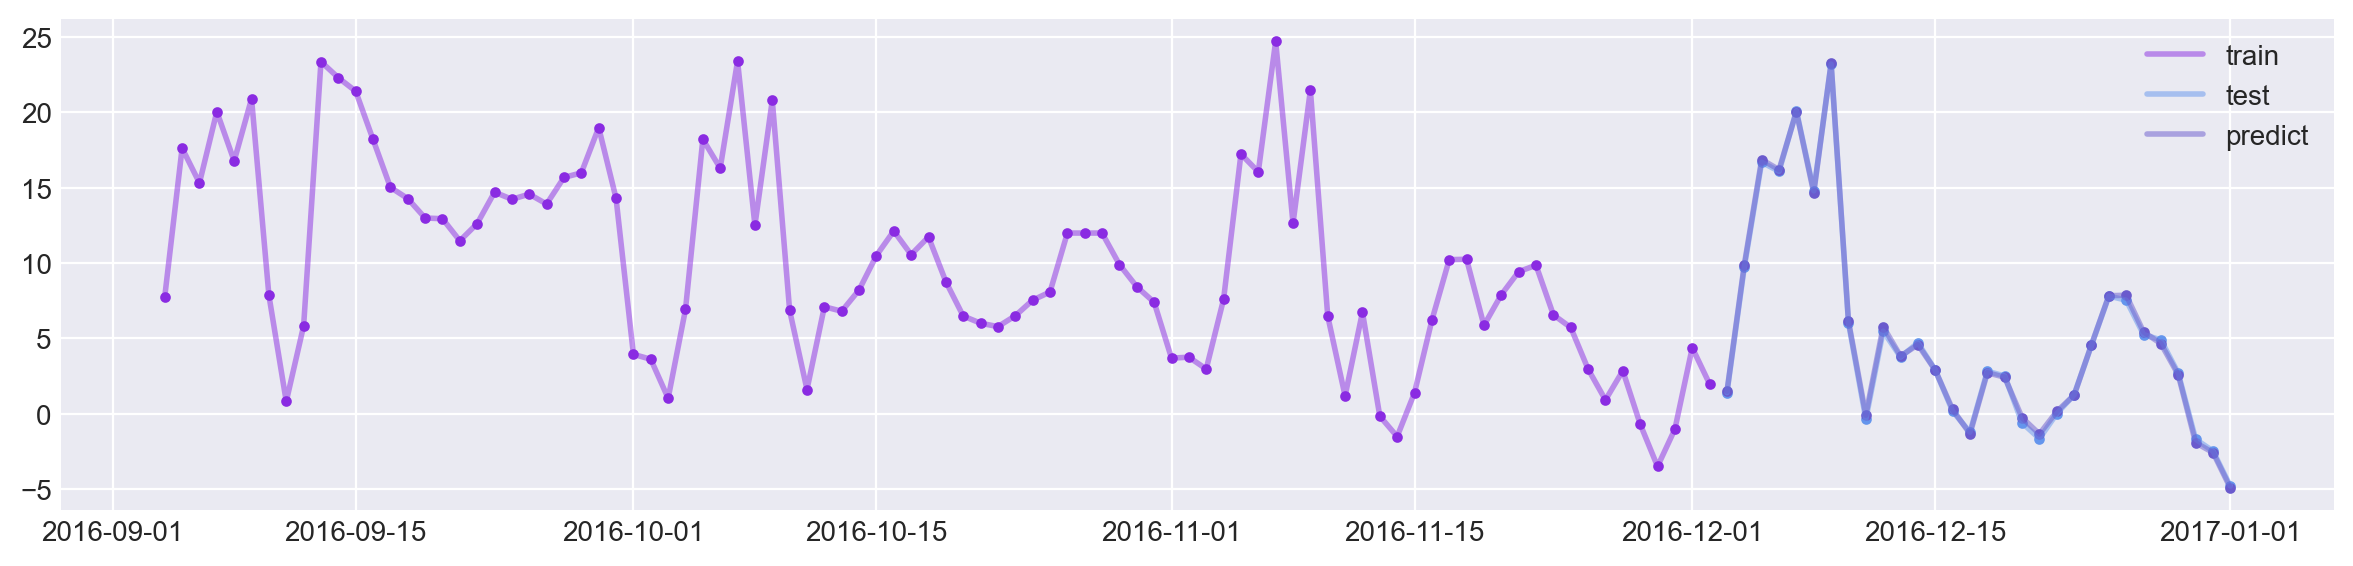

In [23]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [24]:
print(grid_search_results["params"])

{'l2_leaf_reg': 5}


In [25]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 20

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)


train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/20
200/200 [==============================] - 11s 46ms/step - loss: 7.2169 - mae: 1.6808 - val_loss: 1.2361 - val_mae: 1.0504
Epoch 2/20
200/200 [==============================] - 10s 49ms/step - loss: 0.9137 - mae: 0.7049 - val_loss: 0.1150 - val_mae: 0.2727
Epoch 3/20
200/200 [==============================] - 10s 48ms/step - loss: 0.5560 - mae: 0.5524 - val_loss: 0.4569 - val_mae: 0.5803
Epoch 4/20
200/200 [==============================] - 10s 49ms/step - loss: 0.4384 - mae: 0.4796 - val_loss: 0.1977 - val_mae: 0.3701
Epoch 5/20
200/200 [==============================] - 11s 57ms/step - loss: 0.3694 - mae: 0.4079 - val_loss: 0.3933 - val_mae: 0.5346
Epoch 6/20
200/200 [==============================] - 11s 53ms/step - loss: 0.3228 - mae: 0.3869 - val_loss: 0.0456 - val_mae: 0.1639
Epoch 7/20
200/200 [==============================] - 10s 48ms/step - loss: 0.2860 - mae: 0.3497 - val_loss: 0.0564 - val_mae: 0.1848
Epoch 8/20
200/200 [==============================] - 10s 52ms

In [27]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

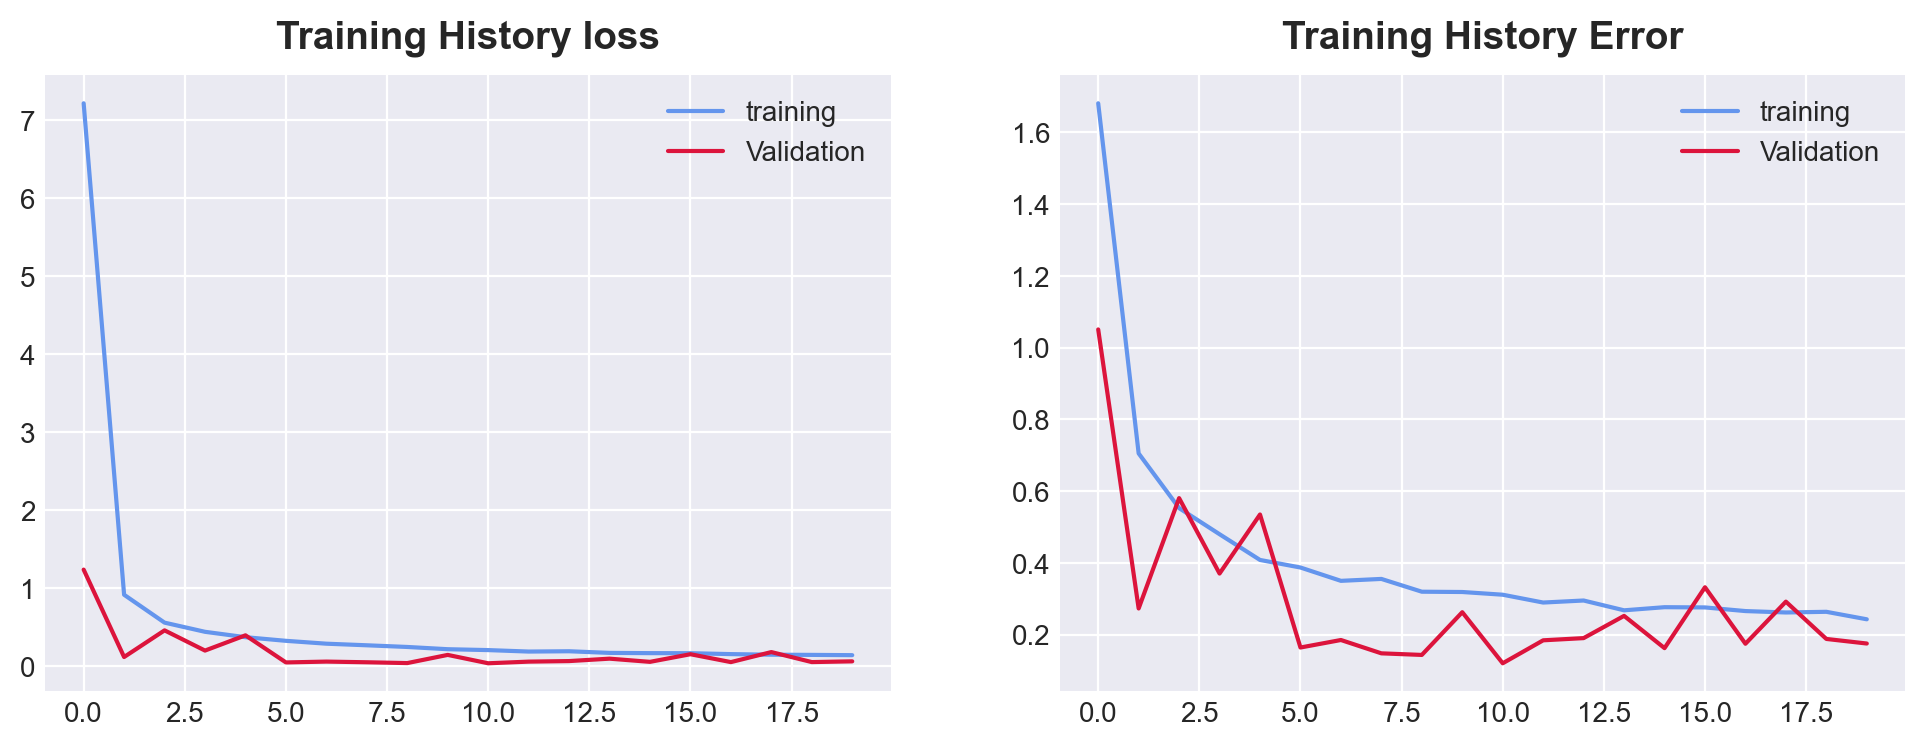

In [28]:
plot_tf_training_history(training_history)

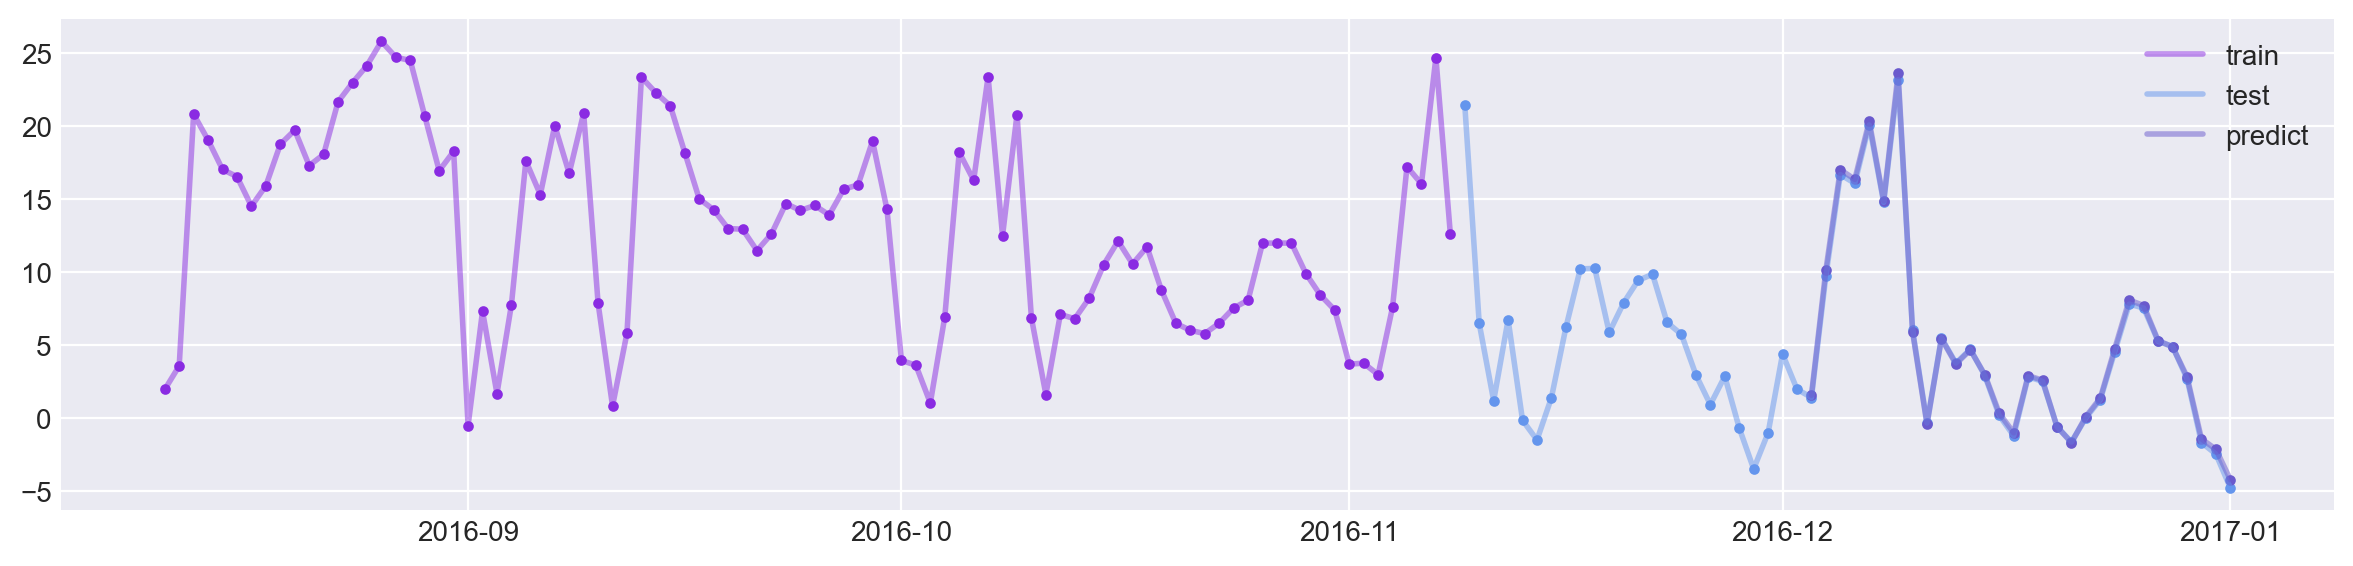

In [29]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [30]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,1.466336,1.298634,0.021444,0.130262,0.109405,0.083151,0.140784,0.175005
rmse,1.824099,5.143928,0.027133,0.153619,0.141218,0.108451,0.168758,0.244171
mape,9.246013,0.621669,0.133205,0.269076,0.233457,0.384615,0.743754,0.298376
r2,0.928317,0.429953,0.999984,0.999492,0.999570,0.999747,0.999386,0.998433


In [31]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,1.466336,1.824099,9.246013,0.928317
BayesianRidge,1.298634,5.143928,0.621669,0.429953
LassoCV,0.021444,0.027133,0.133205,0.999984
RandomForestRegressor,0.130262,0.153619,0.269076,0.999492
XGBRegressor,0.109405,0.141218,0.233457,0.999570
LGBMRegressor,0.083151,0.108451,0.384615,0.999747
CatBoostRegressor,0.140784,0.168758,0.743754,0.999386
LSTM_Dense,0.175005,0.244171,0.298376,0.998433


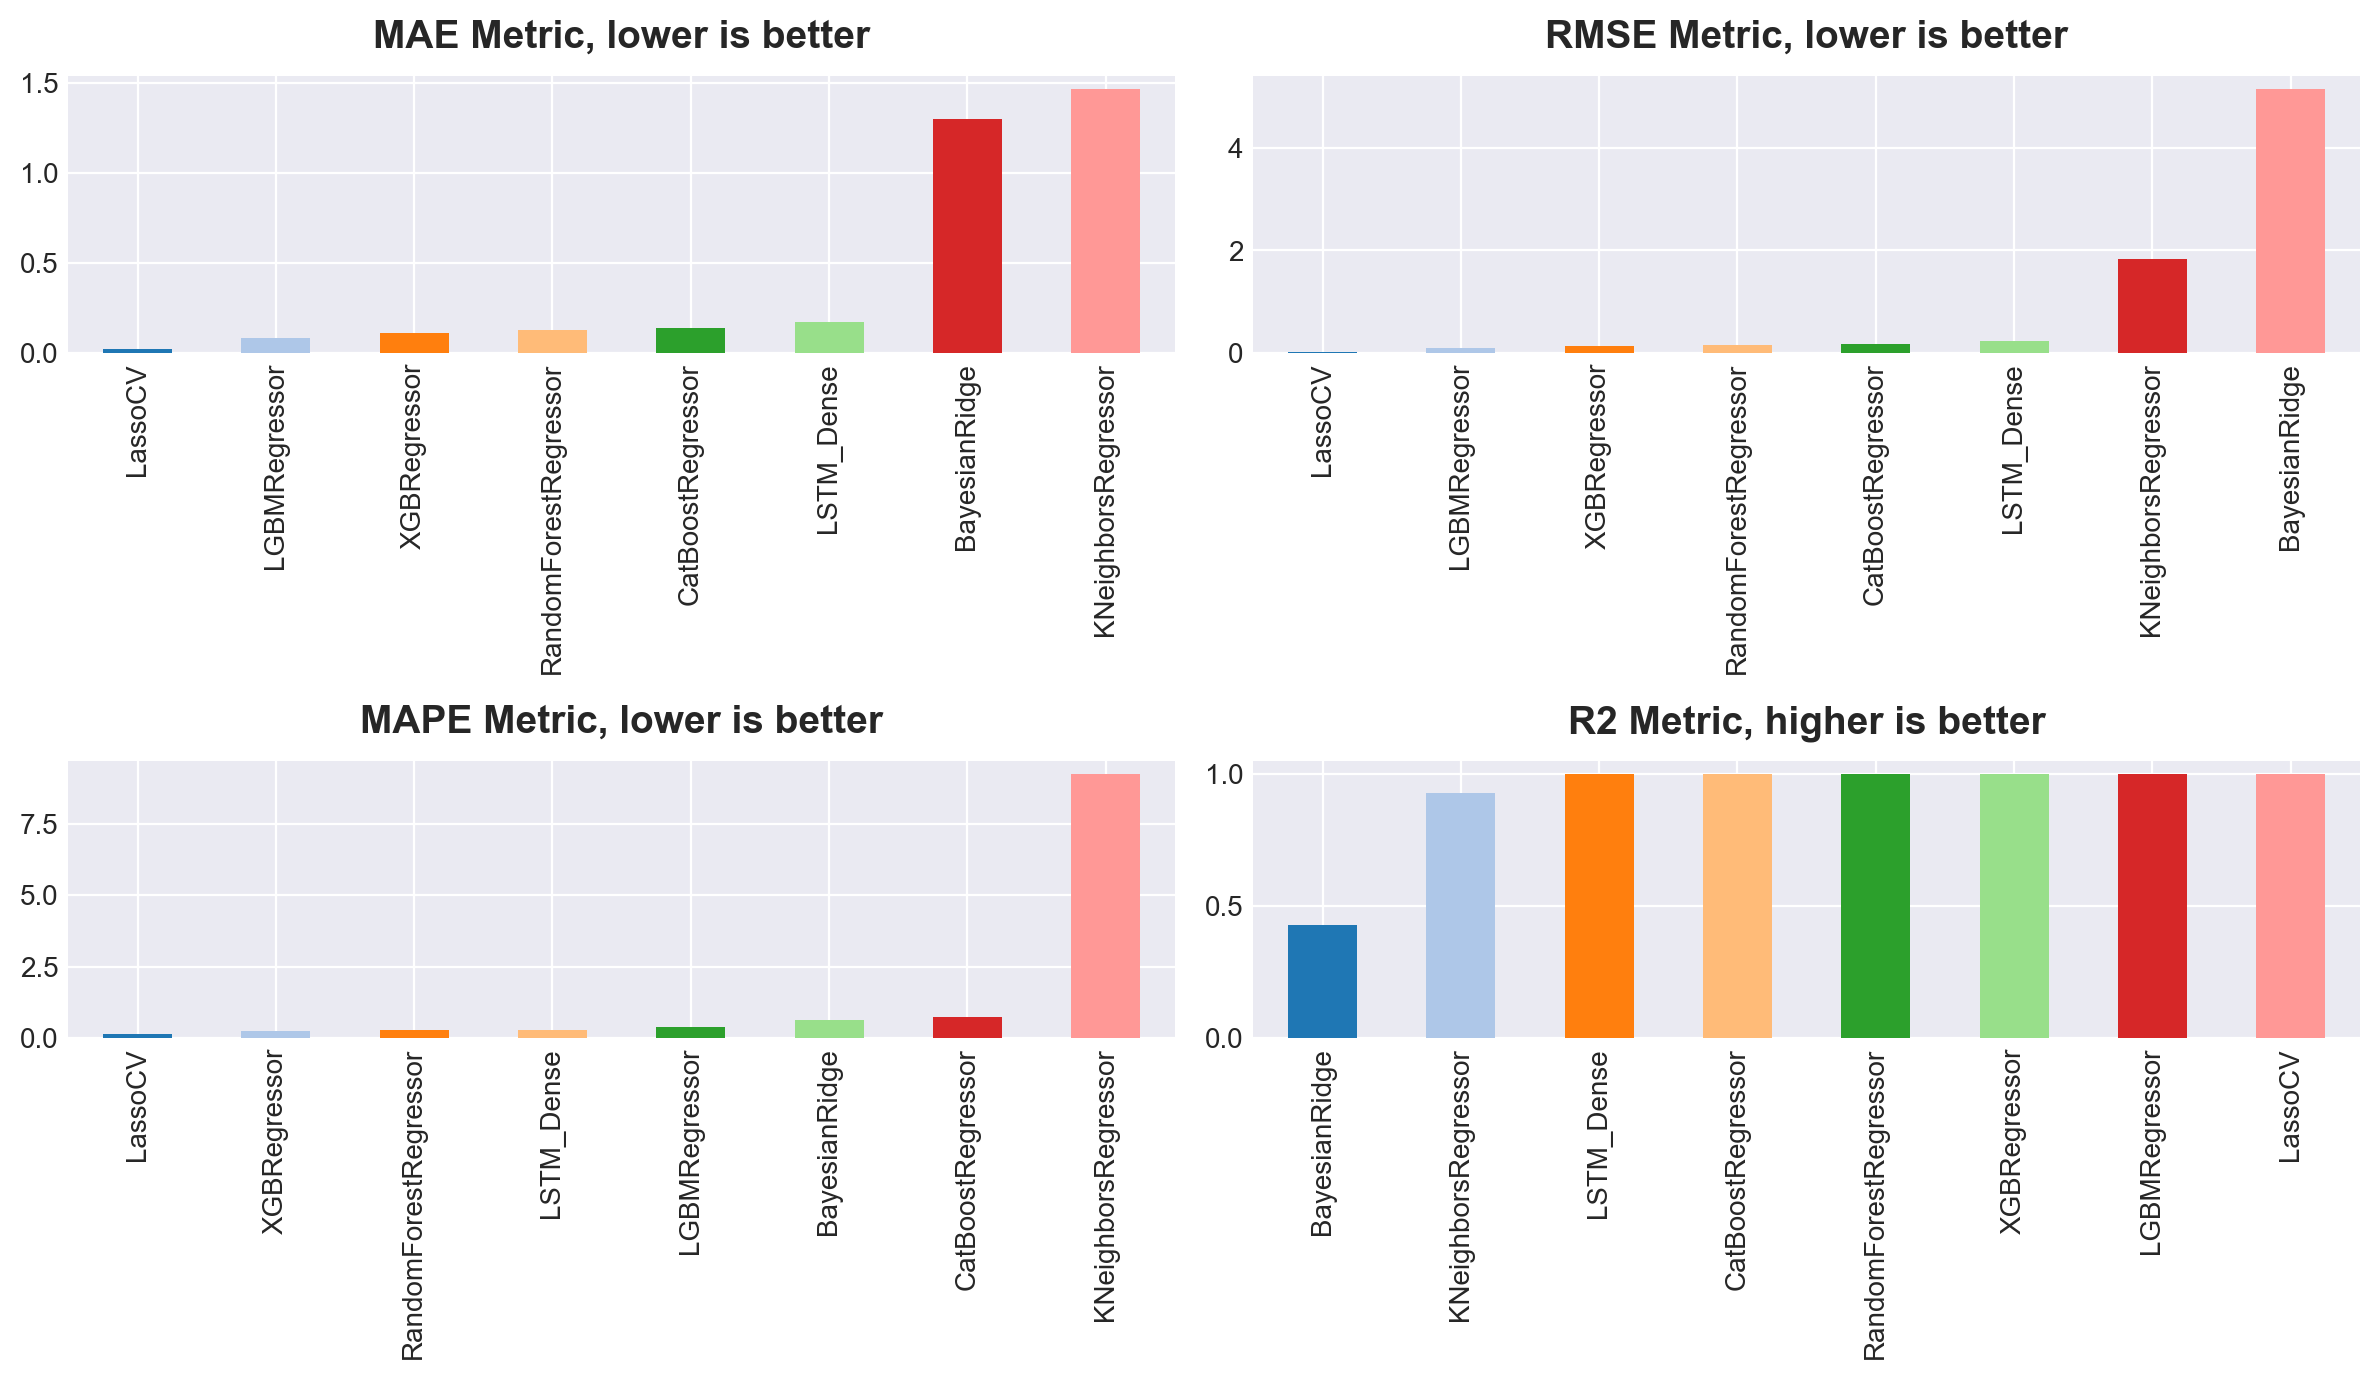

In [33]:
plot_metrics(resultsDF)

In [32]:
resultsDF.T["dataset"] = "Weather"
resultsDF.T["Mode"] = "Singel_step"

resultsDF.T.to_csv("./Weather_results.csv", index=False)